<a href="https://colab.research.google.com/gist/gamble27/95e17fee490b66b8e89318394e968b4b/cpi_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.linear_model as lm
import statsmodels.api as sm
import statsmodels.tsa as tsa
from fbprophet import Prophet
# if Prophet crashes, visit this page:
# https://github.com/dr-prodigy/python-holidays/issues/277

!pip install dtaidistance
from dtaidistance import dtw
from sklearn import metrics
from sklearn.model_selection import train_test_split

import sklearn

import itertools
from tqdm import tqdm

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 327kB 2.8MB/s 
  Created wheel for dtaidistance: filename=dtaidistance-1.2.3-cp36-cp36m-linux_x86_64.whl size=631189 sha256=56ad8a3d8aa58c1a54eee308bddc2d6a816692b14520a92831e27d25a00e056b
  Stored in directory: /root/.cache/pip/wheels/9f/9a/74/42c5b9dc714bb5a70b426df08cc860e6a741bc199004873e1b
Successfully built dtaidistance


# Upload data

In [0]:
from google.colab import files

upl = files.upload()

Saving general2.xlsx to general2.xlsx


### Create dataframe

In [0]:
df = pd.read_excel("general2.xlsx", sheet_name="remove_na")
df = df.dropna()
df.head()

,Country,Code,Year,Month,Economic (GDP) growth percent,Industrial production annual percent change,Retail sales Y-on-Y,Household consumption billion currency units,Consumption as percent of GDP,Consumption growth,Investment billion currency units,Investment as percent of GDP,Investment growth,CPI,CPI monthly percent change,CPI yearly percent change,Employment million people,Unemployment rate percent,Minimum wage,Foreign exchange reserves billion currency units,Government expenditure billion currency units,NBU interest rate,USD exchange rate
0,Ukraine,UKR,2007,3,10.6,6.9,29.0,88.03,63.13,31.24,33.50,24.03,48.26,60.19,0.17,10.06,20.54,7.4,400.0,22.99,24.47,8.5,5.05
1,Ukraine,UKR,2007,6,9.7,7.0,25.0,98.86,59.24,28.85,45.54,27.29,47.95,61.85,2.23,12.88,21.12,5.8,420.0,25.91,31.39,8.0,5.05
2,Ukraine,UKR,2007,9,4.4,5.3,29.7,110.38,55.32,29.06,56.19,28.16,48.11,64.44,2.14,14.36,21.56,5.4,440.0,30.67,30.56,8.0,5.05
3,Ukraine,UKR,2007,12,6.9,0.3,27.6,132.36,61.59,38.47,63.12,29.37,48.30,69.21,1.99,16.61,20.40,6.9,460.0,32.48,42.55,8.0,5.05
4,Ukraine,UKR,2008,3,8.5,2.3,24.7,129.11,67.43,46.67,51.20,26.74,52.82,75.96,3.83,26.21,20.72,7.1,515.0,33.23,32.46,10.0,5.05


In [0]:
df.tail()

,Country,Code,Year,Month,Economic (GDP) growth percent,Industrial production annual percent change,Retail sales Y-on-Y,Household consumption billion currency units,Consumption as percent of GDP,Consumption growth,Investment billion currency units,Investment as percent of GDP,Investment growth,CPI,CPI monthly percent change,CPI yearly percent change,Employment million people,Unemployment rate percent,Minimum wage,Foreign exchange reserves billion currency units,Government expenditure billion currency units,NBU interest rate,USD exchange rate
45,Ukraine,UKR,2018,6,3.8,2.9,5.8,577.15,71.18,21.03,139.70,17.23,35.85,259.8,0.00,10.41,16.53,8.3,3723.0,17.98,188.71,17.0,26.122310
46,Ukraine,UKR,2018,9,2.8,-0.7,6.6,644.80,64.81,24.22,153.66,15.45,29.34,262.9,1.90,8.91,16.66,8.0,3723.0,16.64,158.52,18.0,28.279437
47,Ukraine,UKR,2018,12,3.5,-2.8,4.5,702.65,67.05,21.04,214.29,20.45,23.13,273.3,0.81,9.76,16.22,9.3,3723.0,20.82,233.99,18.0,28.390932
48,Ukraine,UKR,2019,3,2.5,2.1,9.5,664.63,82.28,24.64,126.37,15.64,22.42,279.9,0.90,8.57,16.26,9.2,4173.0,20.63,168.77,18.0,26.859165
49,Ukraine,UKR,2019,6,4.6,-2.3,14.8,708.25,76.34,22.72,155.07,16.71,11.00,283.3,-0.49,9.05,16.71,7.8,4173.0,20.64,200.05,17.5,26.872573


### Create date indices

In [0]:
idx_start = '2007-3-1'
idx_end   = '2019-9-1'
idx = pd.date_range(idx_start, idx_end, freq='Q')
date_index = pd.DatetimeIndex(idx)

In [0]:
df['Date'] = idx

### Create target variables

1. CPI
2. CPI monthly percent change
3. CPI yearly percent change

In [0]:
y_CPI = df['CPI']
y_CPI.index = date_index

y_CPI_m = df['CPI monthly percent change']
y_CPI_m.index = date_index

y_CPI_y = df['CPI yearly percent change']
y_CPI_y.index = date_index

### Create variables data frame (ATTENTION!)

Minimum wage drop


In [0]:
df.columns

Index(['Country', 'Code', 'Year', 'Month', 'Economic (GDP) growth percent',
       'Industrial production annual percent change', 'Retail sales Y-on-Y',
       'Household consumption billion currency units',
       'Consumption as percent of GDP', 'Consumption growth',
       'Investment billion currency units', 'Investment as percent of GDP',
       'Investment growth', 'CPI', 'CPI monthly percent change',
       'CPI yearly percent change', 'Employment million people',
       'Unemployment rate percent', 'Minimum wage',
       'Foreign exchange reserves billion currency units',
       'Government expenditure billion currency units', 'NBU interest rate',
       'USD exchange rate', 'Date'],
      dtype='object')

In [0]:
x = df.copy()
x = x.drop([
            'Country', 'Code',
            'Year', 'Month', 'Date',
            'CPI',
            'CPI monthly percent change',
            'CPI yearly percent change',
            #'Minimum wage', 
], axis=1)
x.index = date_index

### Create merged variable for further analysis

In [0]:
xy_CPI   = x.assign(CPI=y_CPI)
xy_CPI_m = x.assign(CPIm= y_CPI_m)
xy_CPI_y = x.assign(CPIy=y_CPI_y)

## Split training data

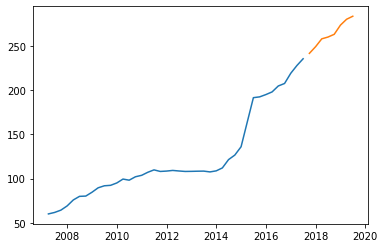

In [0]:
y_CPI_train, y_CPI_test = train_test_split(y_CPI, test_size=0.15, shuffle=False)
fig, ax = plt.subplots()
ax.plot(y_CPI_train.index, y_CPI_train)
ax.plot(y_CPI_test.index, y_CPI_test)

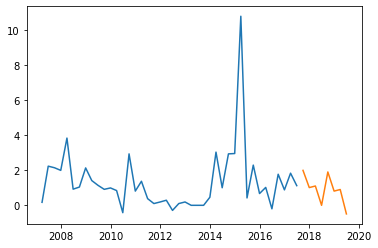

In [0]:
y_CPIm_train, y_CPIm_test = train_test_split(y_CPI_m, test_size=0.15, shuffle=False)
fig, ax = plt.subplots()
ax.plot(y_CPIm_train.index, y_CPIm_train)
ax.plot(y_CPIm_test.index, y_CPIm_test)

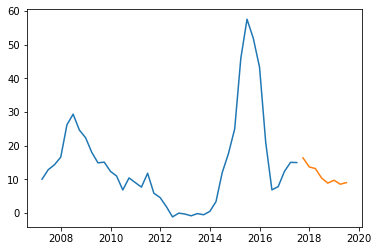

In [0]:
y_CPIy_train, y_CPIy_test = train_test_split(y_CPI_y, test_size=0.15, shuffle=False)
fig, ax = plt.subplots()
ax.plot(y_CPIy_train.index, y_CPIy_train)
ax.plot(y_CPIy_test.index, y_CPIy_test)

In [0]:
# manual split needed
x_train = x.loc[y_CPI_train.index,]
x_test  = x.loc[y_CPI_test.index, ]

In [0]:
# manual split for VARMA
xy_CPI_train = xy_CPI.loc[y_CPI_train.index,]
xy_CPI_test = xy_CPI.loc[y_CPI_test.index, ]

xy_CPIm_train = xy_CPI_m.loc[y_CPI_train.index,]
xy_CPIm_test = xy_CPI_m.loc[y_CPI_test.index, ]

xy_CPIy_train = xy_CPI_m.loc[y_CPI_train.index,]
xy_CPIy_test = xy_CPI_m.loc[y_CPI_test.index, ]

In [0]:
# single multitargeted Y for regression
y_train = pd.DataFrame({
    'CPI' : y_CPI_train,
    'CPIm': y_CPIm_train,
    'CPIy': y_CPIy_train
})

y_test = pd.DataFrame({
    'CPI' : y_CPI_test,
    'CPIm': y_CPIm_test,
    'CPIy': y_CPIy_test
})

y_train.index = list(range(len(y_train.index)))
y_test.index = list(range(len(y_test.index)))

# Visual analysis

### Define some helpful functions

Visualisation of:

1. Rolling mean
2. Autocorrelation
3. Seasonal decomposition
4. Pair plot
5. Correlation plot
6. Multicollinearity test

In [0]:
# rolling mean
def rolling(x, window=12): 
    # Determining rolling statistics
    rolmean = x.rolling(window=window, center=False).mean()
    # rolstd = x.rolling(window=12, center=False).std() 
    
    # Plot rolling statistics
    orig = plt.plot(x.values, color='blue', label='Original') 
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean') 
    # std = plt.plot(rolstd.values, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [0]:
# autocorrelation
def autocorr(x, max_lag=36):
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(x.values.squeeze(), lags=max_lag, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(x, lags=max_lag, ax=ax2)

In [0]:
# seasonal decomposition
def seasonal(x):
    decompose = tsa.seasonal.seasonal_decompose(x)

    fig, ax = plt.subplots(nrows=4, figsize=(15,15))
    ax[0].plot(x.index, decompose.observed)
    ax[0].set_title('observed')
    ax[1].plot(x.index, decompose.seasonal)
    ax[1].set_title('seasonal')
    ax[2].plot(x.index, decompose.trend)
    ax[2].set_title('trend')
    ax[3].plot(x.index, decompose.resid)
    ax[3].set_title('residuals')
    fig.show()

In [0]:
# pairplot
def pairplot(df):
    plt.figure(figsize=(20,20))
    sns.pairplot(df)
    plt.show()

In [0]:
# corrplot
def corrplot(df):
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # plot
    plt.figure(figsize=(20,20))
    sns.heatmap(corr, mask=mask, annot=True, xticklabels=True, yticklabels=True)
    plt.show()

    # make annotation manually
    # print(*df.columns, sep='\n')

In [0]:
# multicollinearity test
def vif_test(x, xy, y_name):
    """
    vif > 5 => bad;
    multicollinearity exists
    """
    x1 = sklearn.preprocessing.scale(x)
    vif_df = pd.DataFrame()
    vif_df["VIF Factor"] = [vif(x1, i) for i in range(x1.shape[1])]
    vif_df["features"] = x.columns
    vif_df = vif_df.round(1)
    corr = xy.corr()
    corr = corr[y_name]
    corr = corr.round(3)
    del corr[y_name]
    vif_df[f'r({y_name}, X)'] = [corr[feature] for feature in vif_df['features']]
    return vif_df.sort_values(by=[f'r({y_name}, X)'])

### 1. CPI

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_CPI.index, y=y_CPI,
                    mode='lines',
                    name='CPI'))

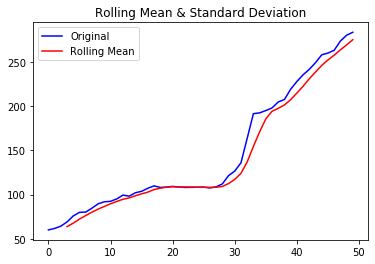

In [0]:
rolling(y_CPI, window=4)

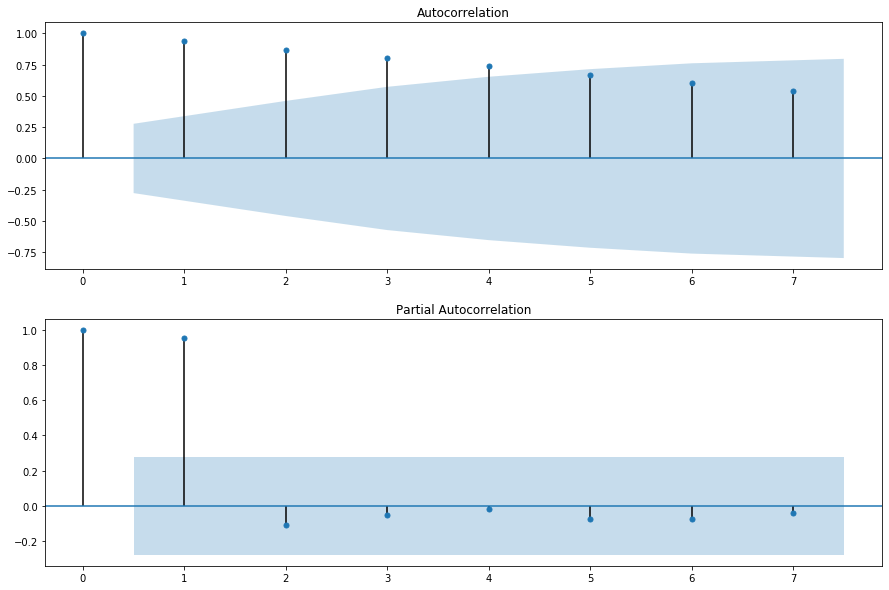

In [0]:
autocorr(y_CPI, max_lag=7)

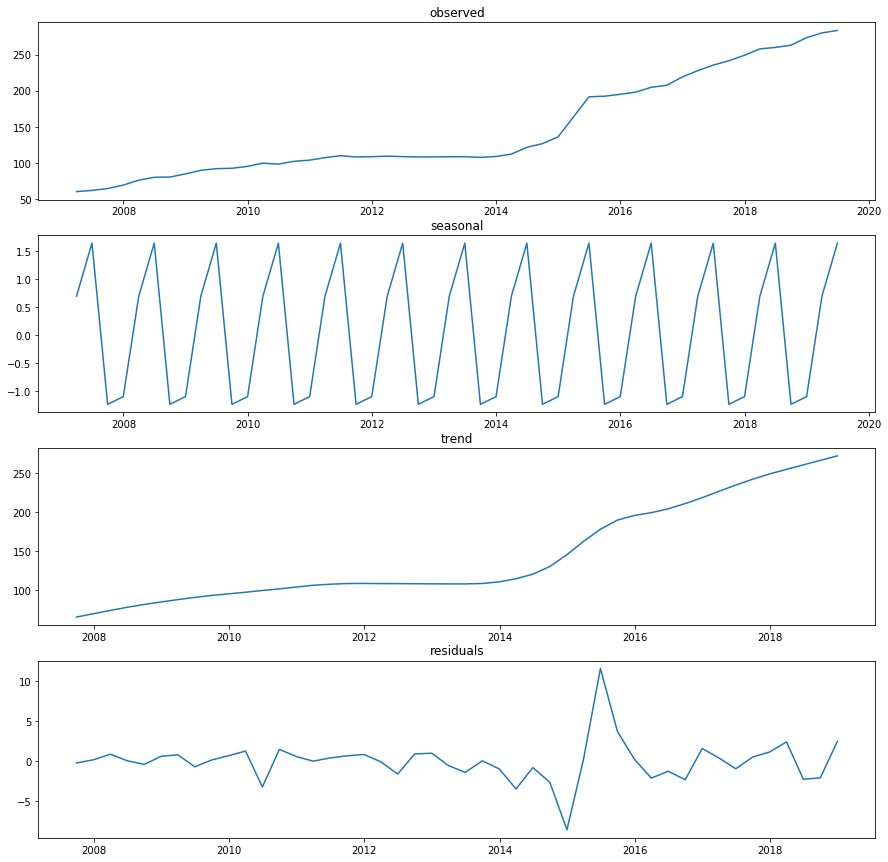

In [0]:
seasonal(y_CPI)

<Figure size 1440x1440 with 0 Axes>

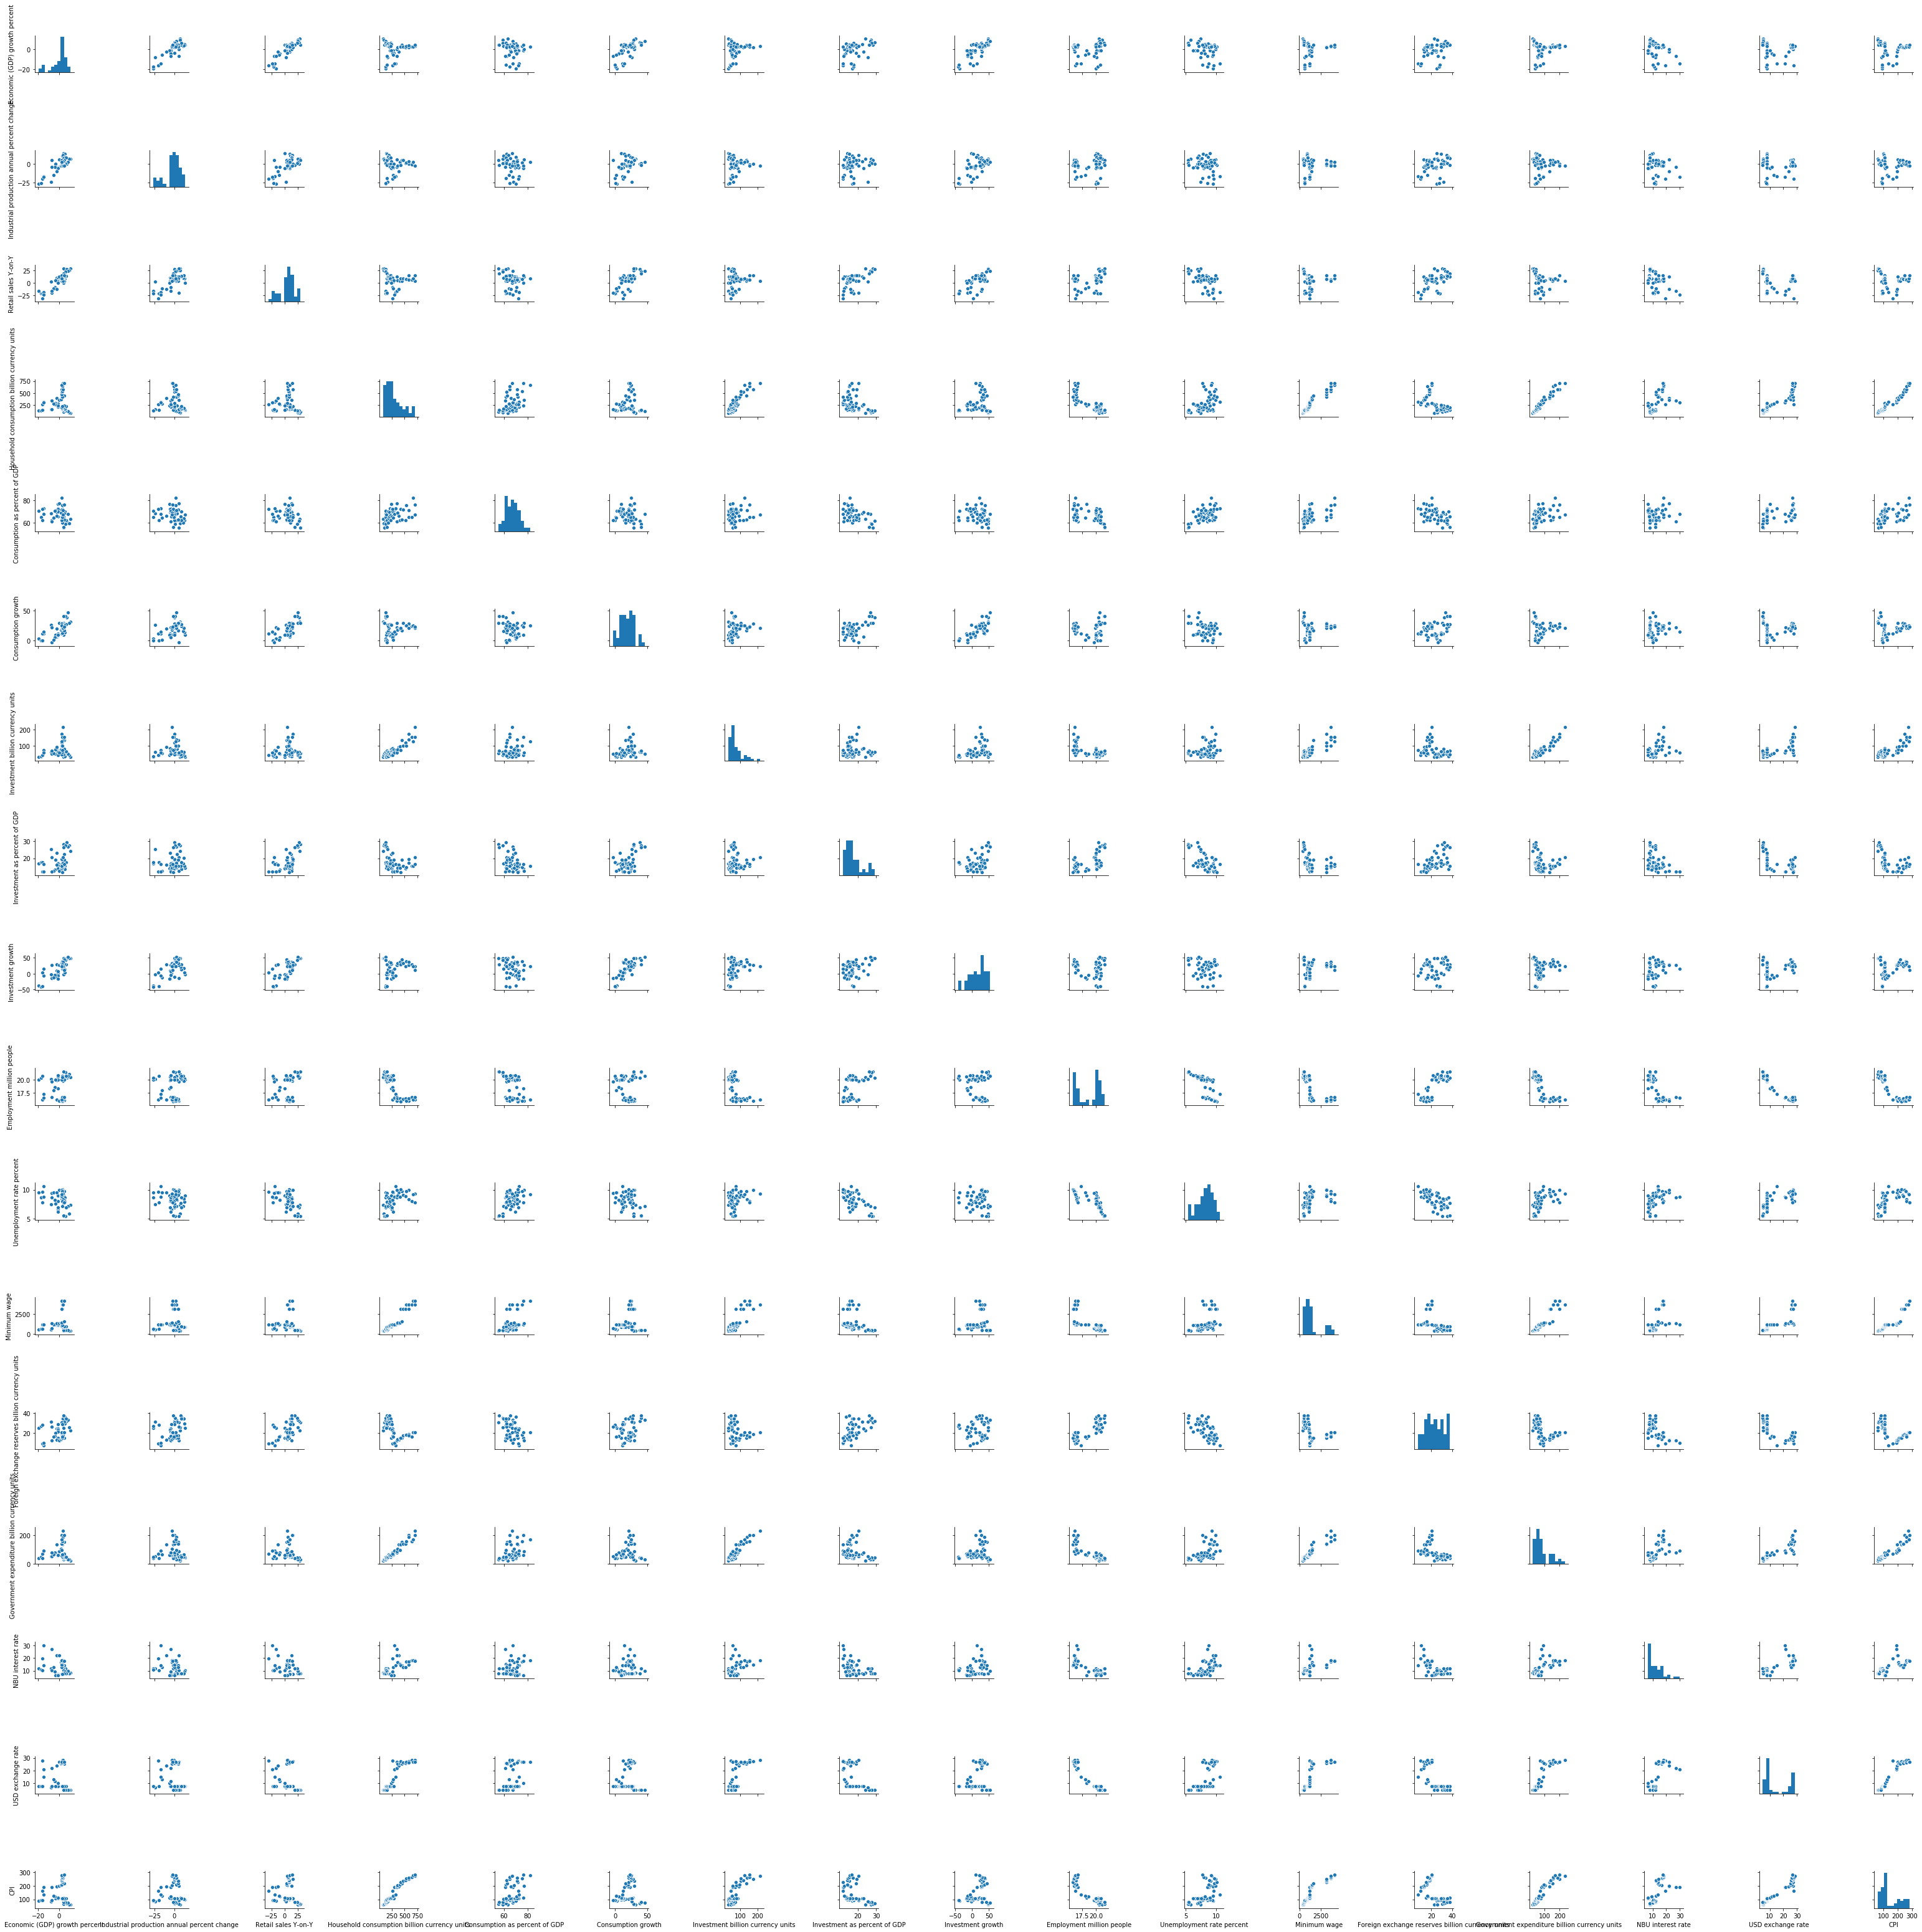

In [0]:
pairplot(xy_CPI)

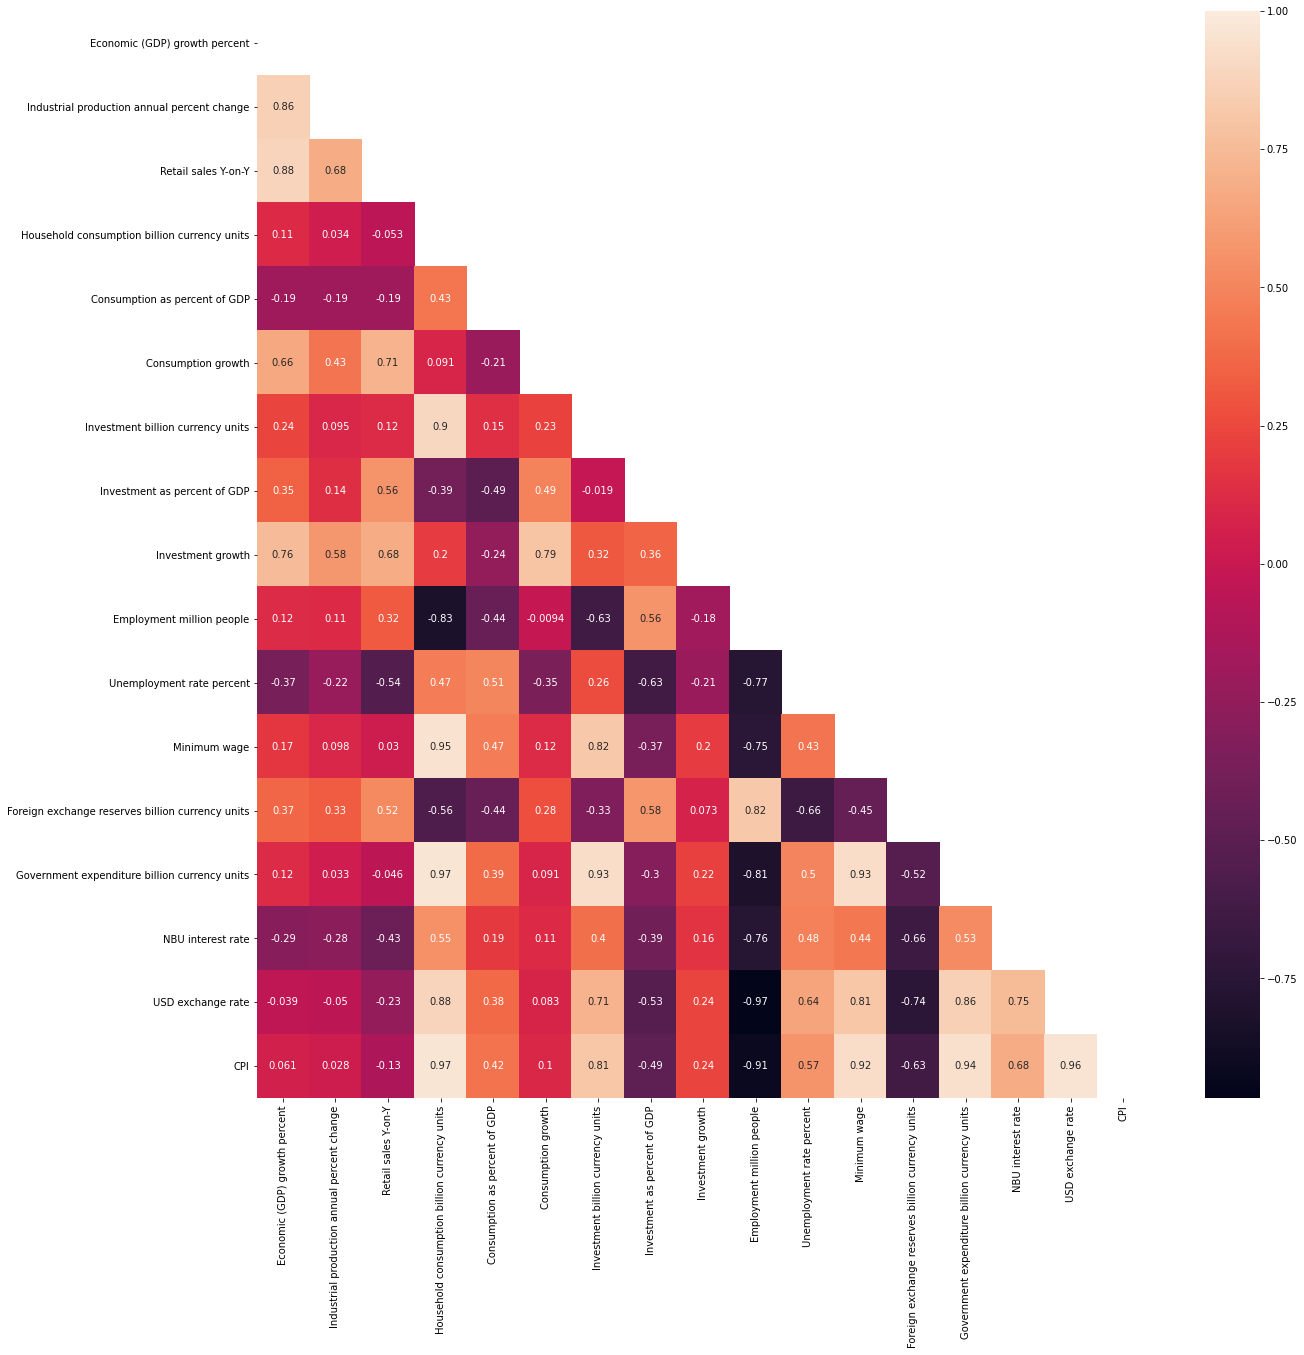

In [0]:
corrplot(xy_CPI)

#### Multicollinearity test

Minimum wage is present here

Intuition: VIF factor should be less than 5, but in our case this seems to be impossible. So we will try to remove some variables to reduce multicollinearity, and hence the model with scaled variables could explain which factors have the biggest influence on response. 

In [0]:
vif_test(x, xy_CPI, 'CPI')

,VIF Factor,features,"r(CPI, X)"
9,111.0,Employment million people,-0.911
12,8.6,Foreign exchange reserves billion currency units,-0.626
7,10.3,Investment as percent of GDP,-0.486
2,11.7,Retail sales Y-on-Y,-0.129
1,5.9,Industrial production annual percent change,0.028
0,17.6,Economic (GDP) growth percent,0.061
5,7.0,Consumption growth,0.102
8,7.6,Investment growth,0.237
4,5.1,Consumption as percent of GDP,0.419
10,13.2,Unemployment rate percent,0.567


we can see that household consumtion (A) and employment (B) make trouble

r(A,B) = -0.83

by removing one of them can reduce vif factor of another one

In [0]:
drop_label = ['Household consumption billion currency units']
vif_test(x.drop(drop_label, axis=1), xy_CPI.drop(drop_label, axis=1), 'CPI')

,VIF Factor,features,"r(CPI, X)"
8,95.5,Employment million people,-0.911
11,8.6,Foreign exchange reserves billion currency units,-0.626
6,5.8,Investment as percent of GDP,-0.486
2,11.6,Retail sales Y-on-Y,-0.129
1,5.9,Industrial production annual percent change,0.028
0,17.4,Economic (GDP) growth percent,0.061
4,6.8,Consumption growth,0.102
7,7.5,Investment growth,0.237
3,2.9,Consumption as percent of GDP,0.419
9,10.1,Unemployment rate percent,0.567


In [0]:
drop_label = ['Employment million people']
vif_test(x.drop(drop_label, axis=1), xy_CPI.drop(drop_label, axis=1), 'CPI')

,VIF Factor,features,"r(CPI, X)"
11,4.8,Foreign exchange reserves billion currency units,-0.626
7,10.0,Investment as percent of GDP,-0.486
2,11.4,Retail sales Y-on-Y,-0.129
1,5.7,Industrial production annual percent change,0.028
0,17.5,Economic (GDP) growth percent,0.061
5,6.2,Consumption growth,0.102
8,7.2,Investment growth,0.237
4,4.6,Consumption as percent of GDP,0.419
9,4.1,Unemployment rate percent,0.567
13,6.1,NBU interest rate,0.678


lets also drop minimum wage

In [0]:
drop_label = [ 'Minimum wage']
vif_test(x.drop(drop_label, axis=1), xy_CPI.drop(drop_label, axis=1), 'CPI')

,VIF Factor,features,"r(CPI, X)"
9,102.0,Employment million people,-0.911
11,8.6,Foreign exchange reserves billion currency units,-0.626
7,8.2,Investment as percent of GDP,-0.486
2,11.6,Retail sales Y-on-Y,-0.129
1,5.9,Industrial production annual percent change,0.028
0,17.4,Economic (GDP) growth percent,0.061
5,6.7,Consumption growth,0.102
8,7.6,Investment growth,0.237
4,4.3,Consumption as percent of GDP,0.419
10,12.2,Unemployment rate percent,0.567


finally:

In [0]:
drop_label = ['Employment million people', 'Minimum wage']
vif_test(x.drop(drop_label, axis=1), xy_CPI.drop(drop_label, axis=1), 'CPI')

,VIF Factor,features,"r(CPI, X)"
10,4.3,Foreign exchange reserves billion currency units,-0.626
7,8.2,Investment as percent of GDP,-0.486
2,11.4,Retail sales Y-on-Y,-0.129
1,5.7,Industrial production annual percent change,0.028
0,17.1,Economic (GDP) growth percent,0.061
5,6.1,Consumption growth,0.102
8,7.1,Investment growth,0.237
4,4.1,Consumption as percent of GDP,0.419
9,4.1,Unemployment rate percent,0.567
12,5.6,NBU interest rate,0.678


looks good, but I will only remove minimum wage

### 2. CPI monthly percent change

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_CPI_m.index, y=y_CPI_m,
                    mode='lines',
                    name='CPI monthly percent change'))

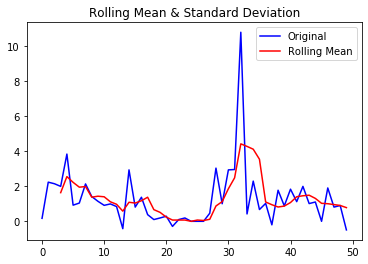

In [0]:
rolling(y_CPI_m, window=4)

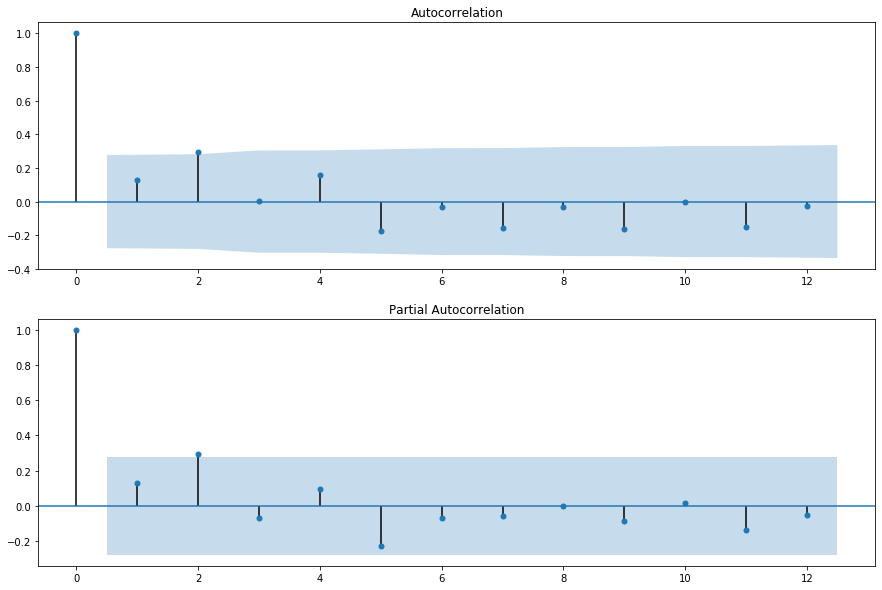

In [0]:
autocorr(y_CPI_m, max_lag=12)

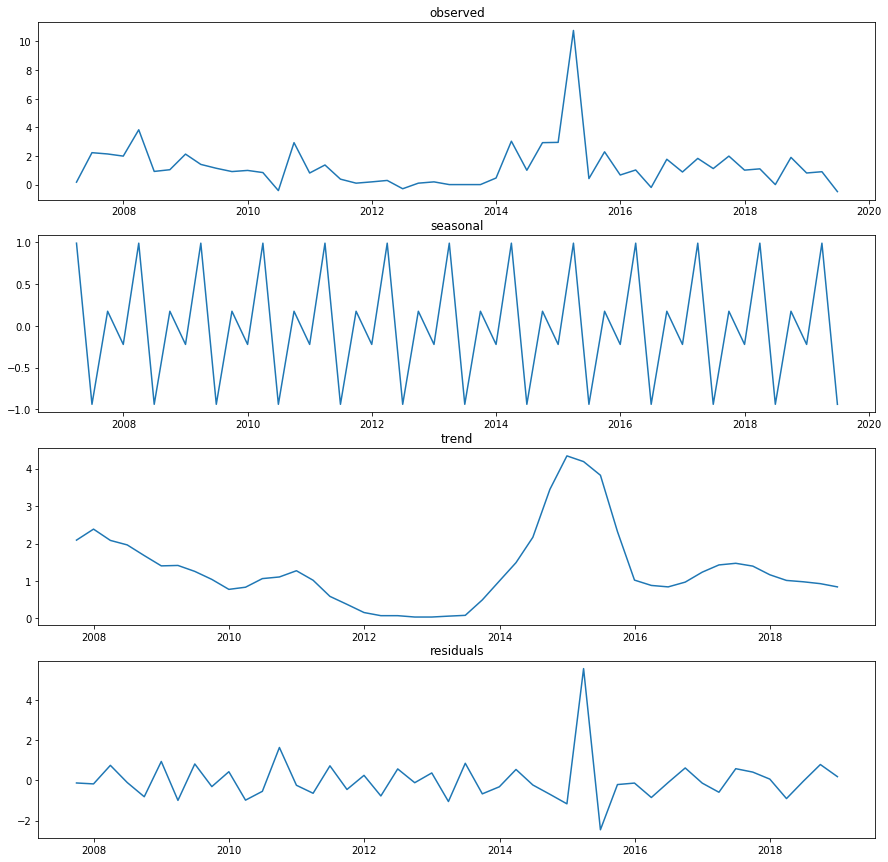

In [0]:
seasonal(y_CPI_m)

<Figure size 1440x1440 with 0 Axes>

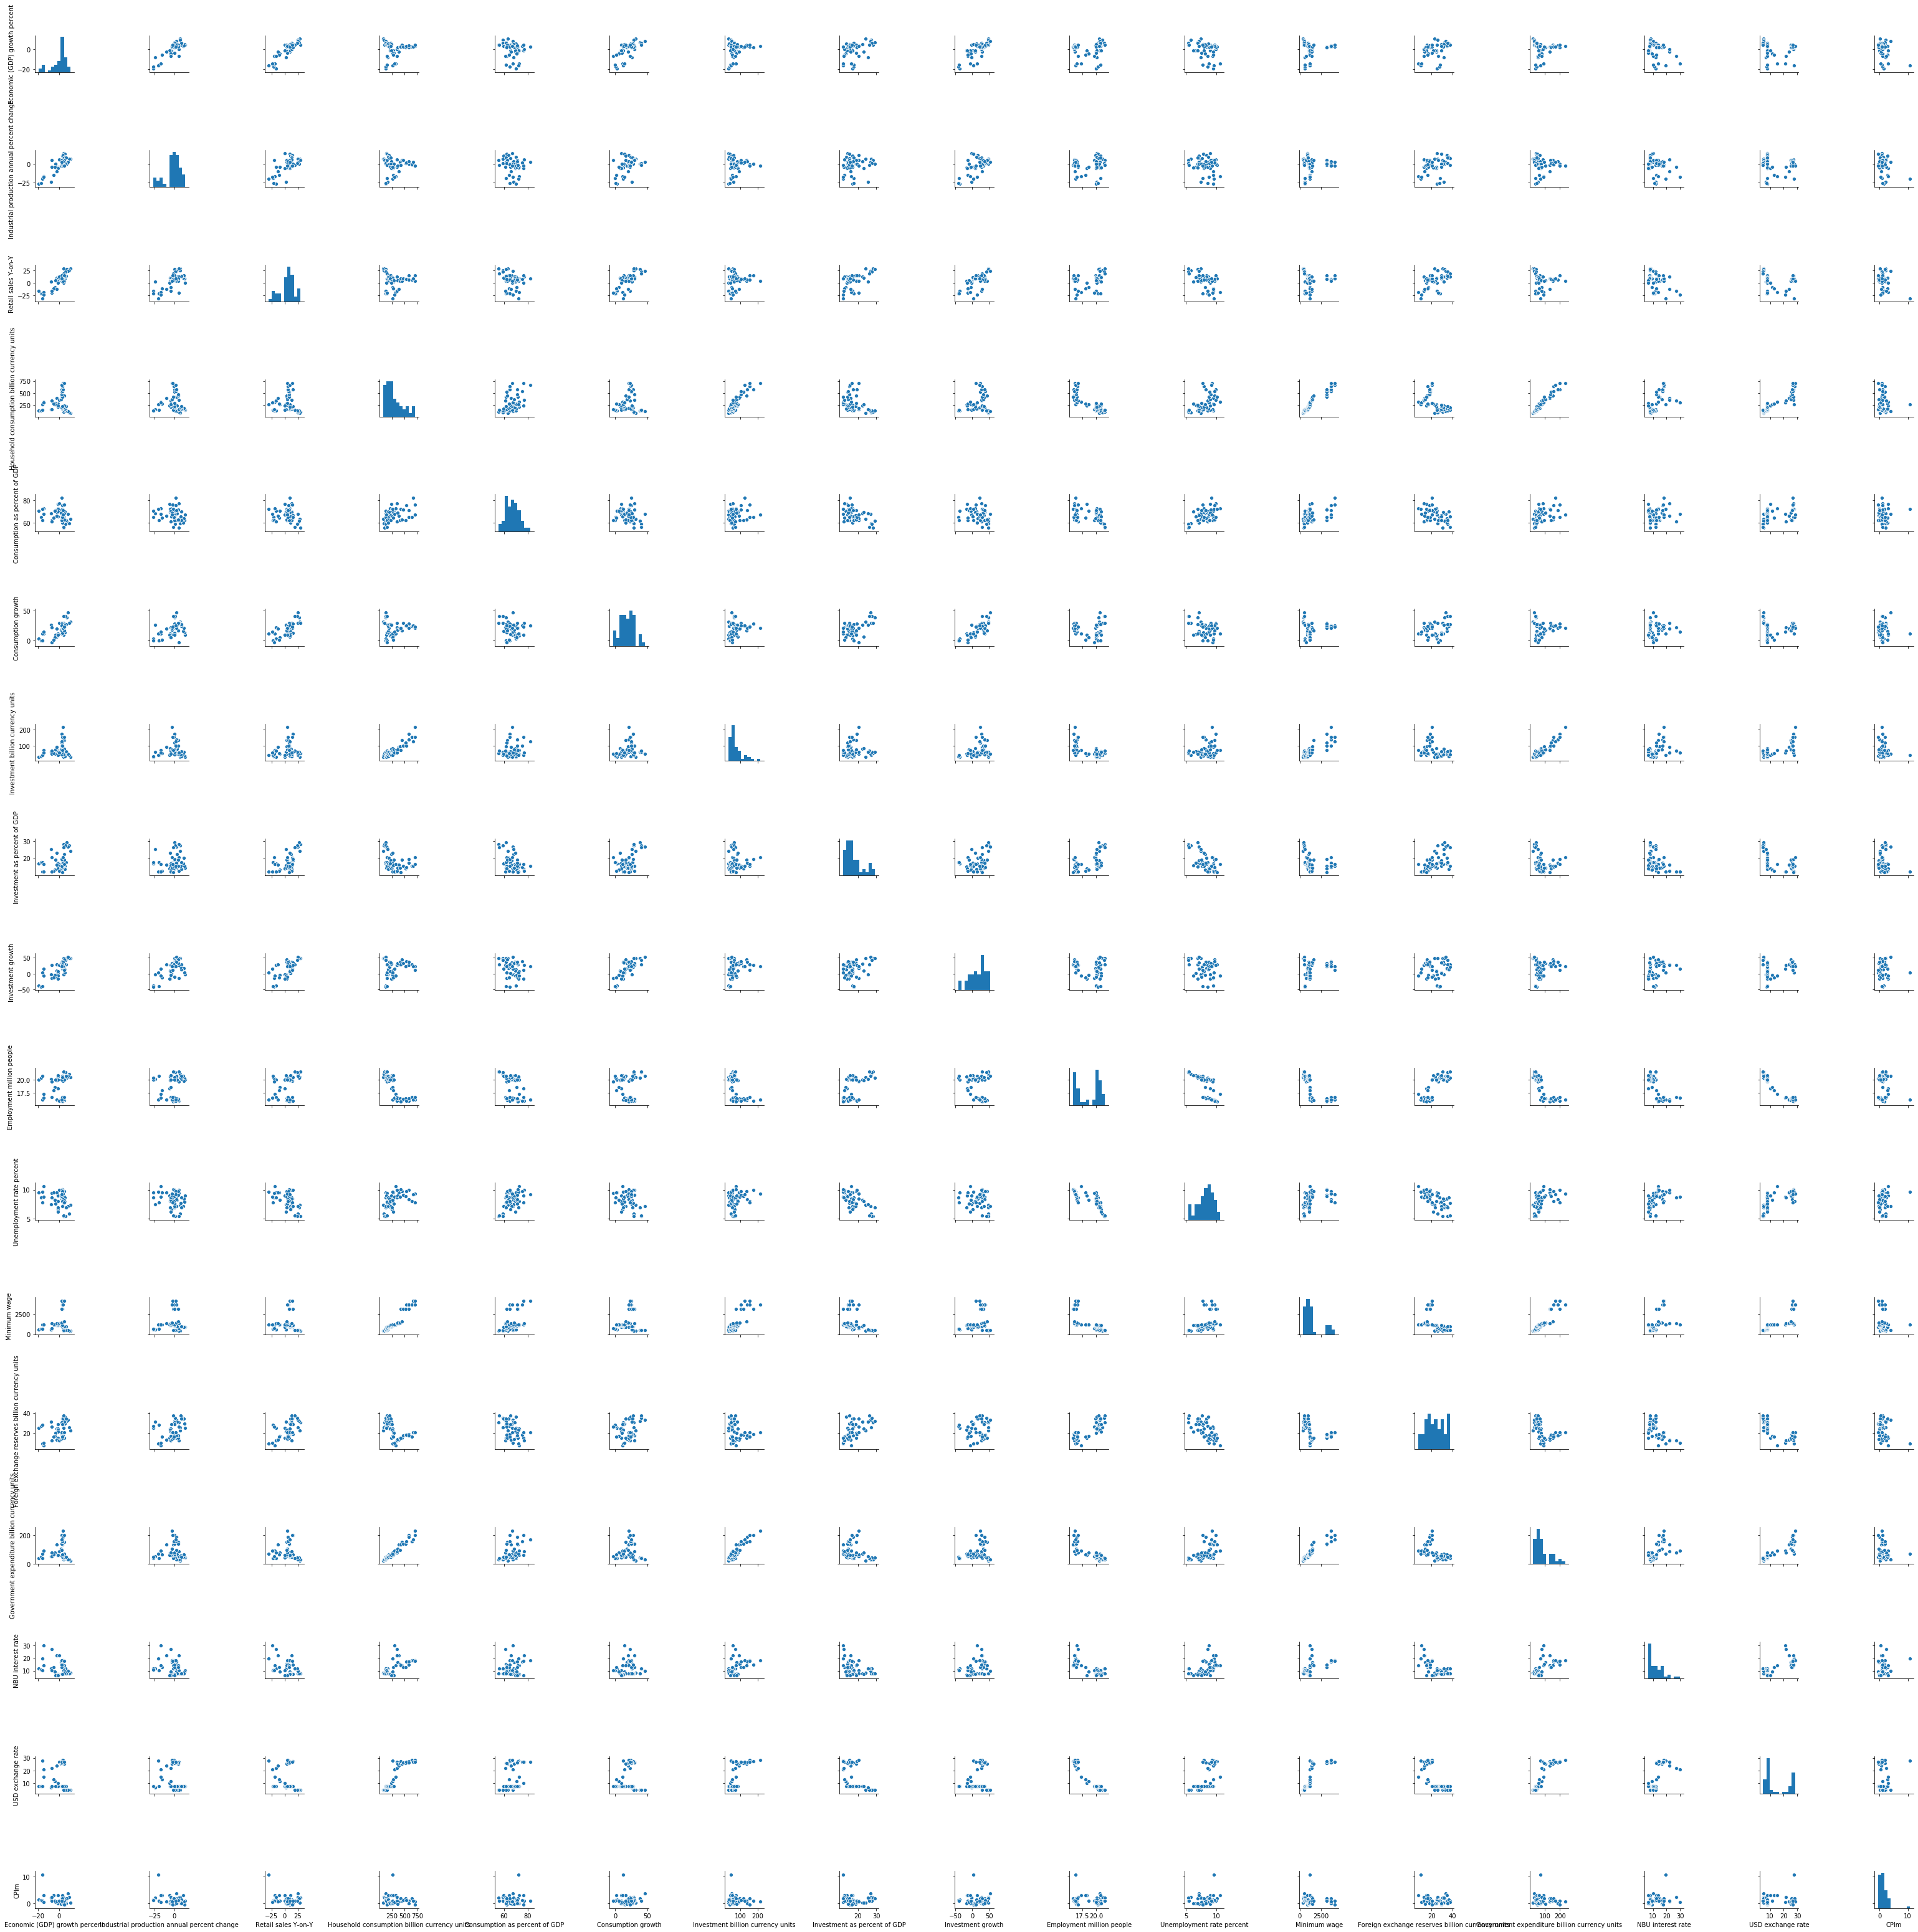

In [0]:
pairplot(xy_CPI_m)

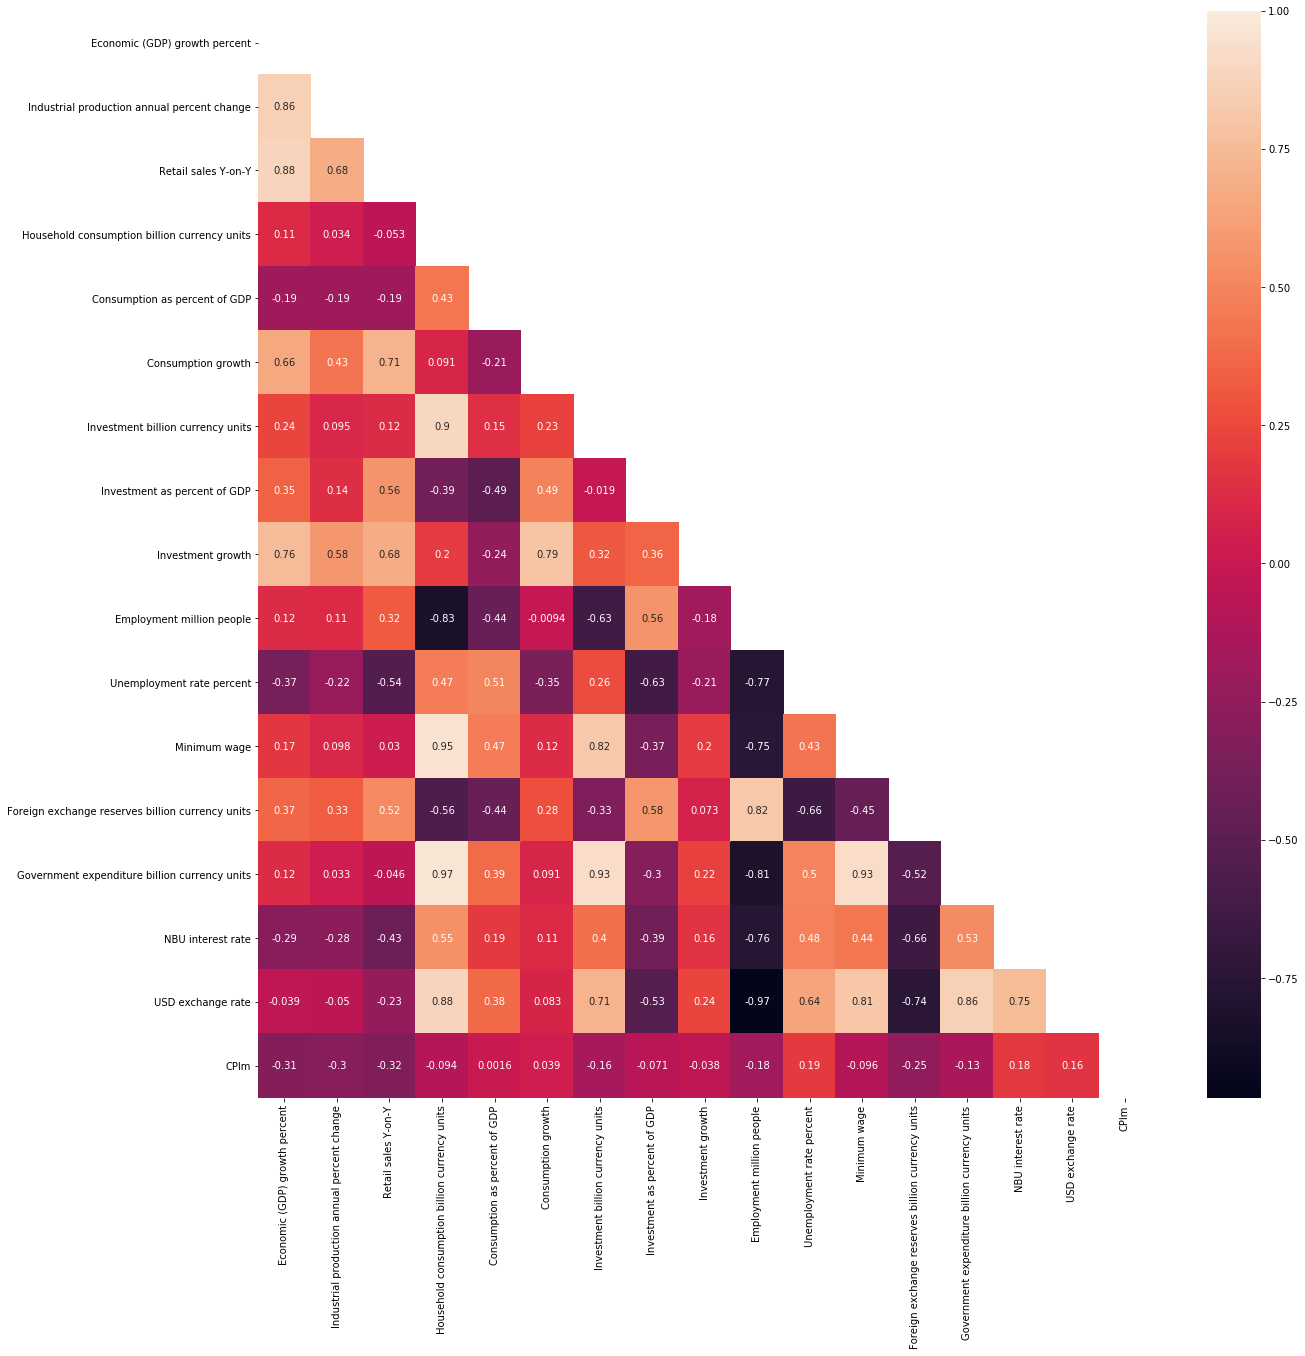

In [0]:
corrplot(xy_CPI_m)

In [0]:
vif_test(x, xy_CPI_m, 'CPIm')

,VIF Factor,features,"r(CPIm, X)"
2,12.6,Retail sales Y-on-Y,-0.325
0,16.9,Economic (GDP) growth percent,-0.311
1,5.9,Industrial production annual percent change,-0.298
11,51.0,Foreign exchange reserves billion currency units,-0.246
9,461.5,Employment million people,-0.182
6,204.1,Investment billion currency units,-0.158
12,144.7,Government expenditure billion currency units,-0.130
3,258.3,Household consumption billion currency units,-0.094
7,127.8,Investment as percent of GDP,-0.071
8,10.6,Investment growth,-0.038


### 3. CPI yearly percent change

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_CPI_y.index, y=y_CPI_y,
                    mode='lines',
                    name='CPI yearly percent change'))

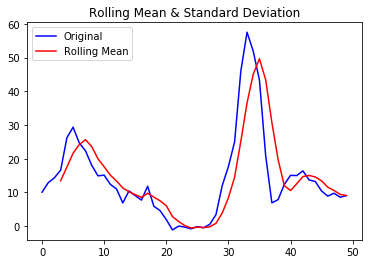

In [0]:
rolling(y_CPI_y, window=4)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



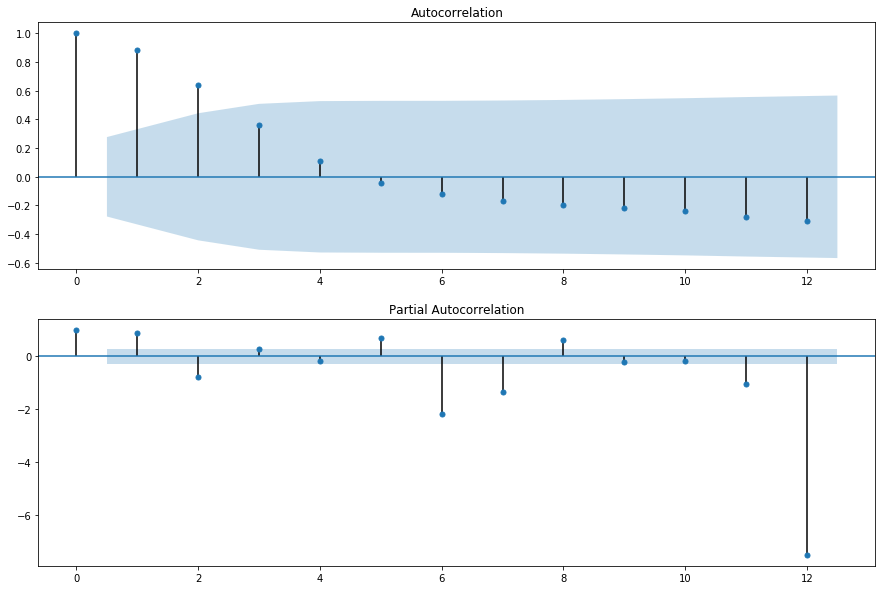

In [0]:
autocorr(y_CPI_y, max_lag=12)

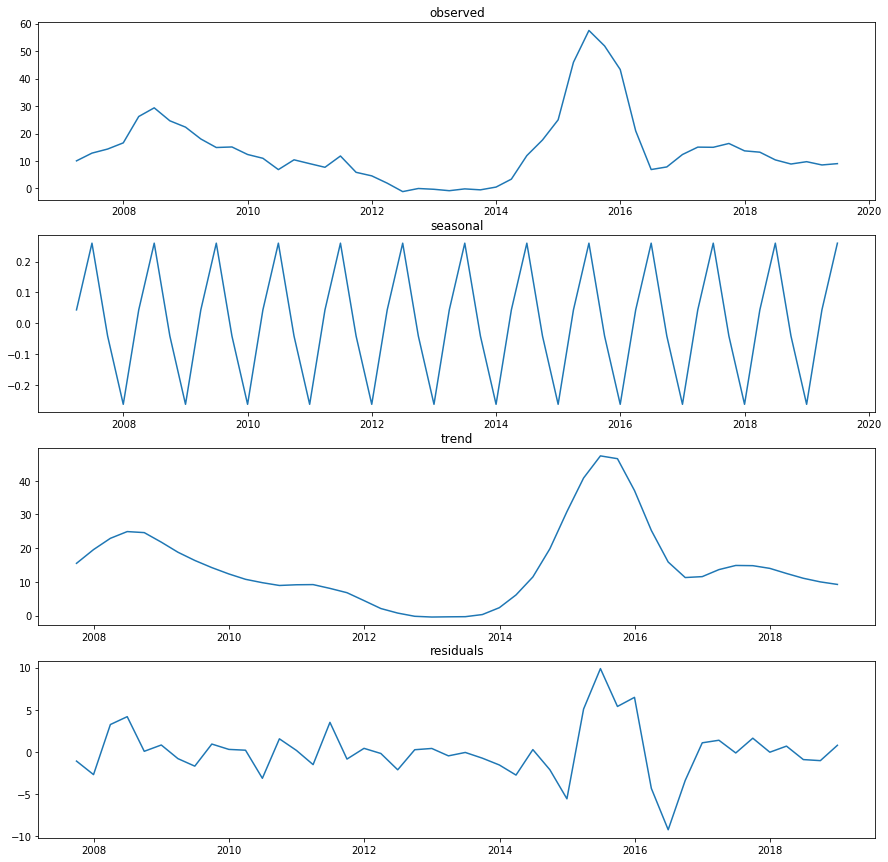

In [0]:
seasonal(y_CPI_y)

<Figure size 1440x1440 with 0 Axes>

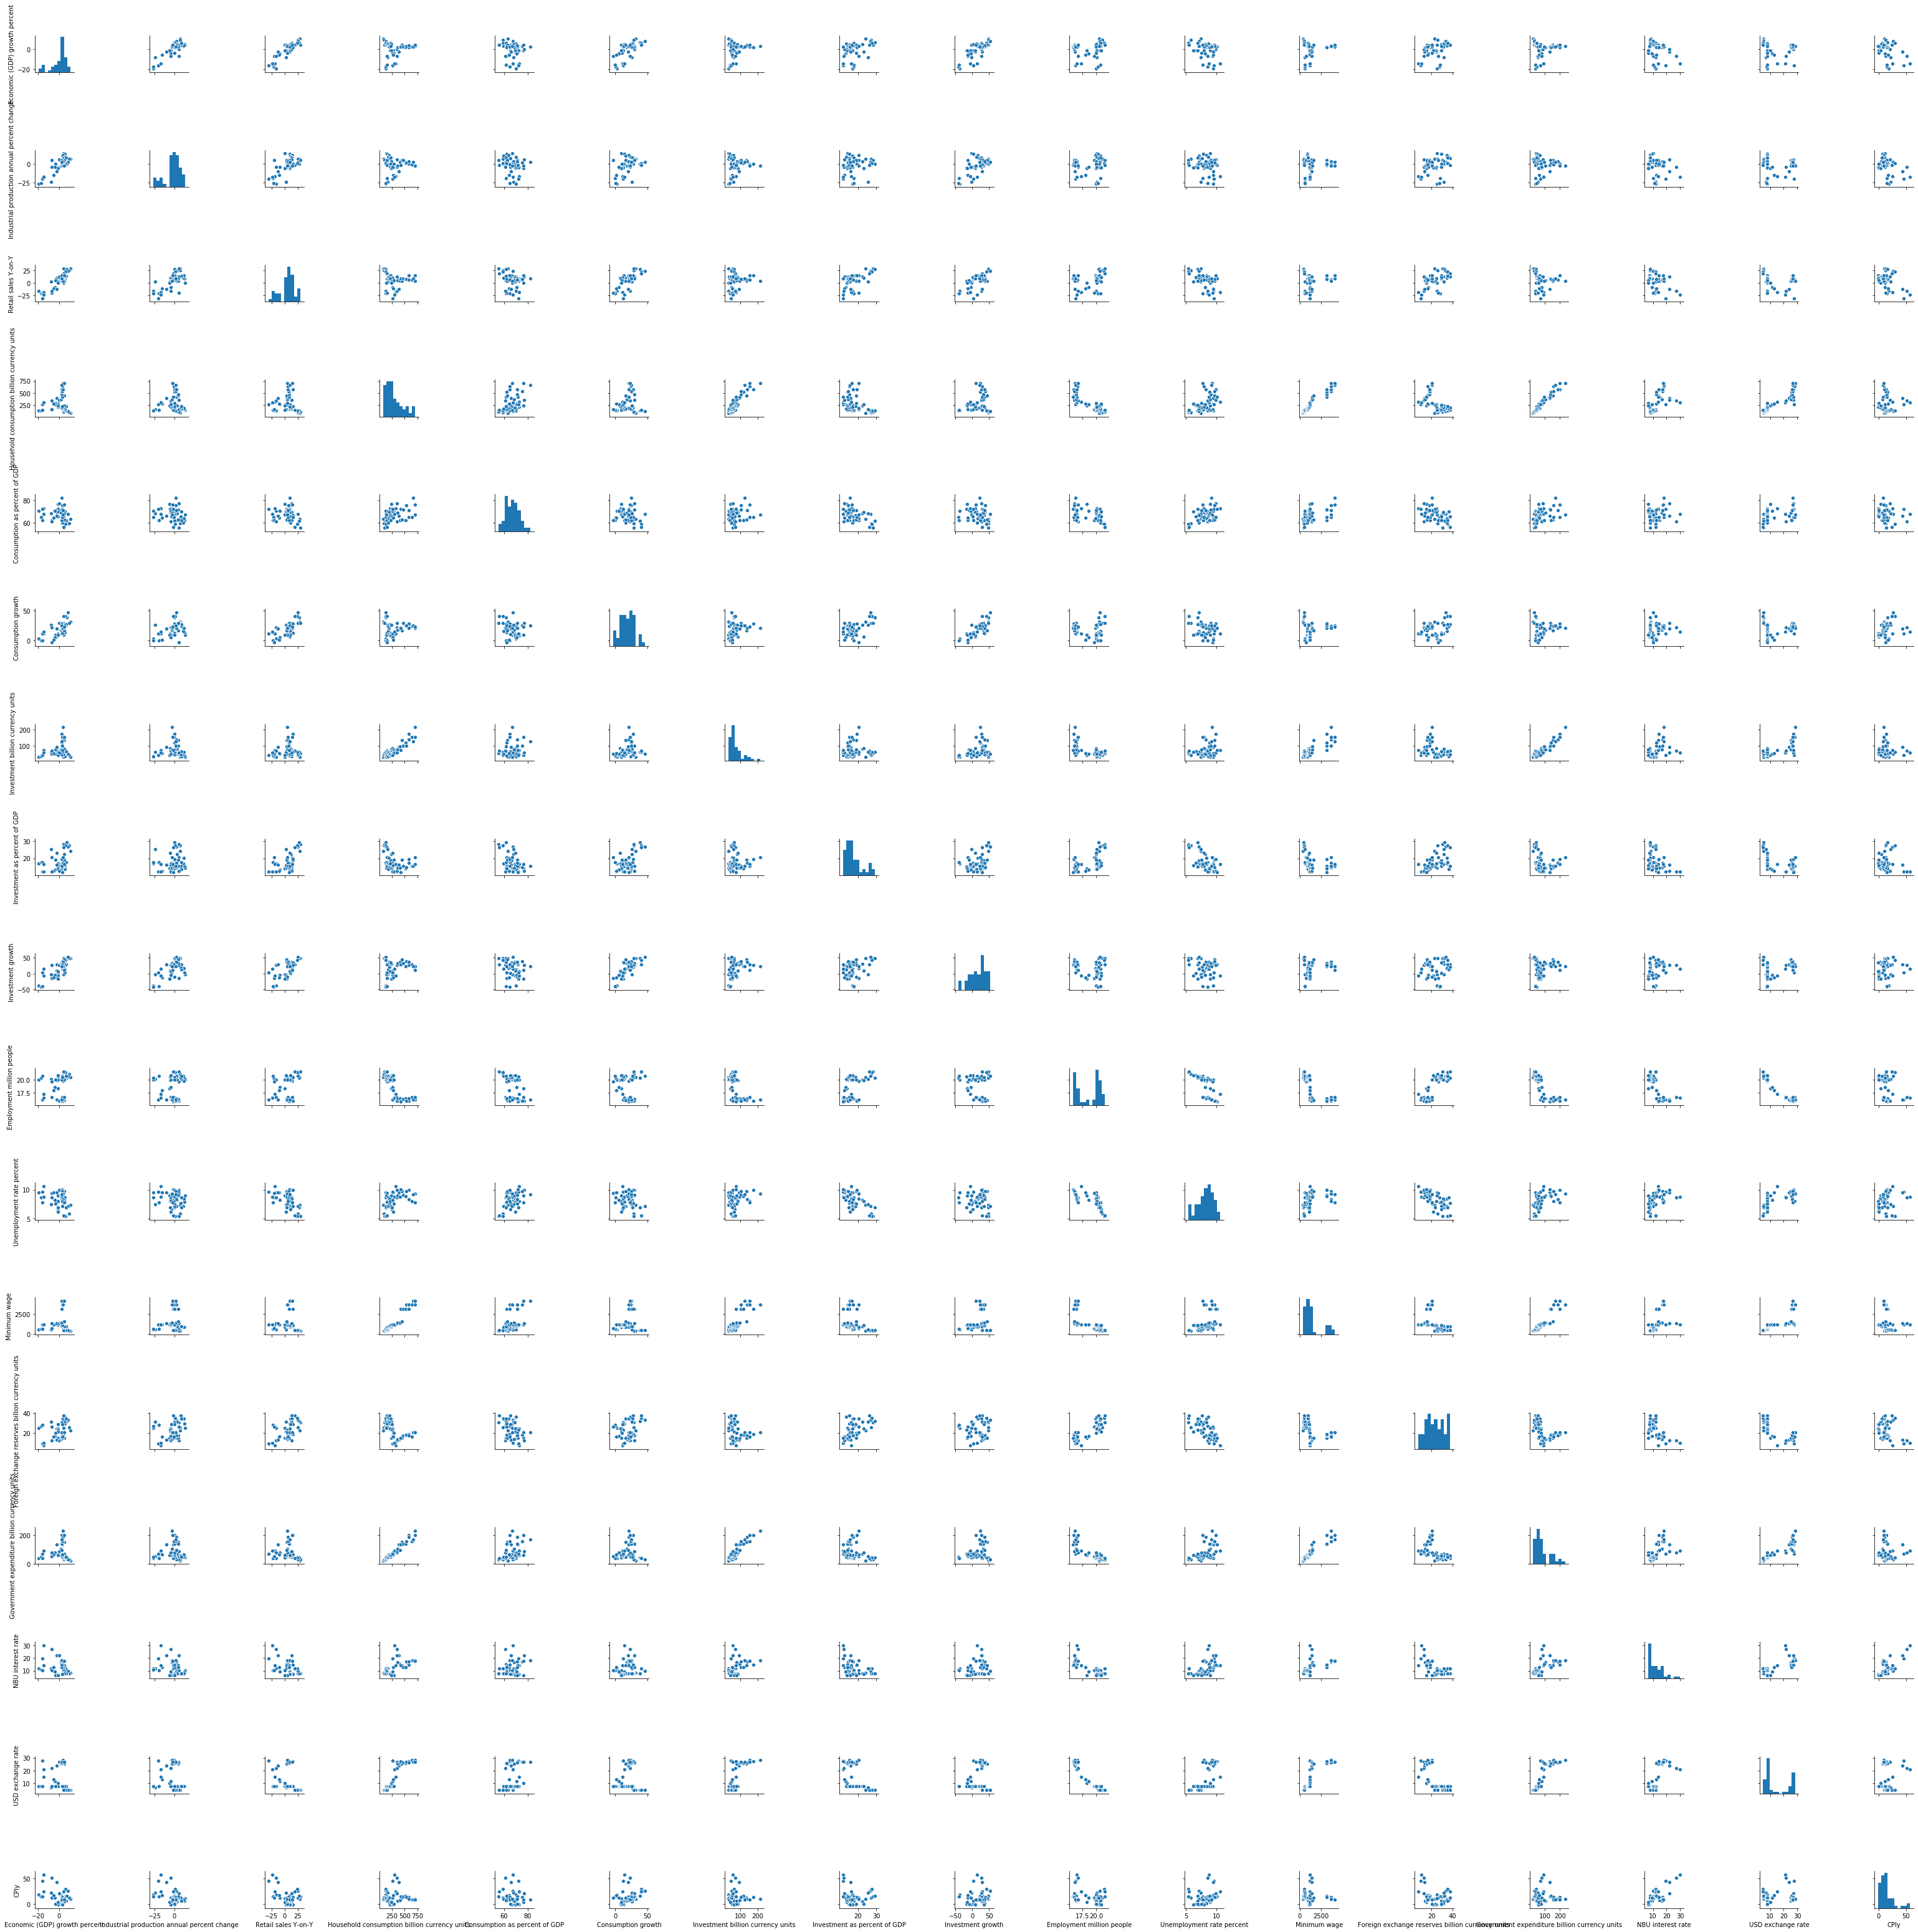

In [0]:
pairplot(xy_CPI_y)

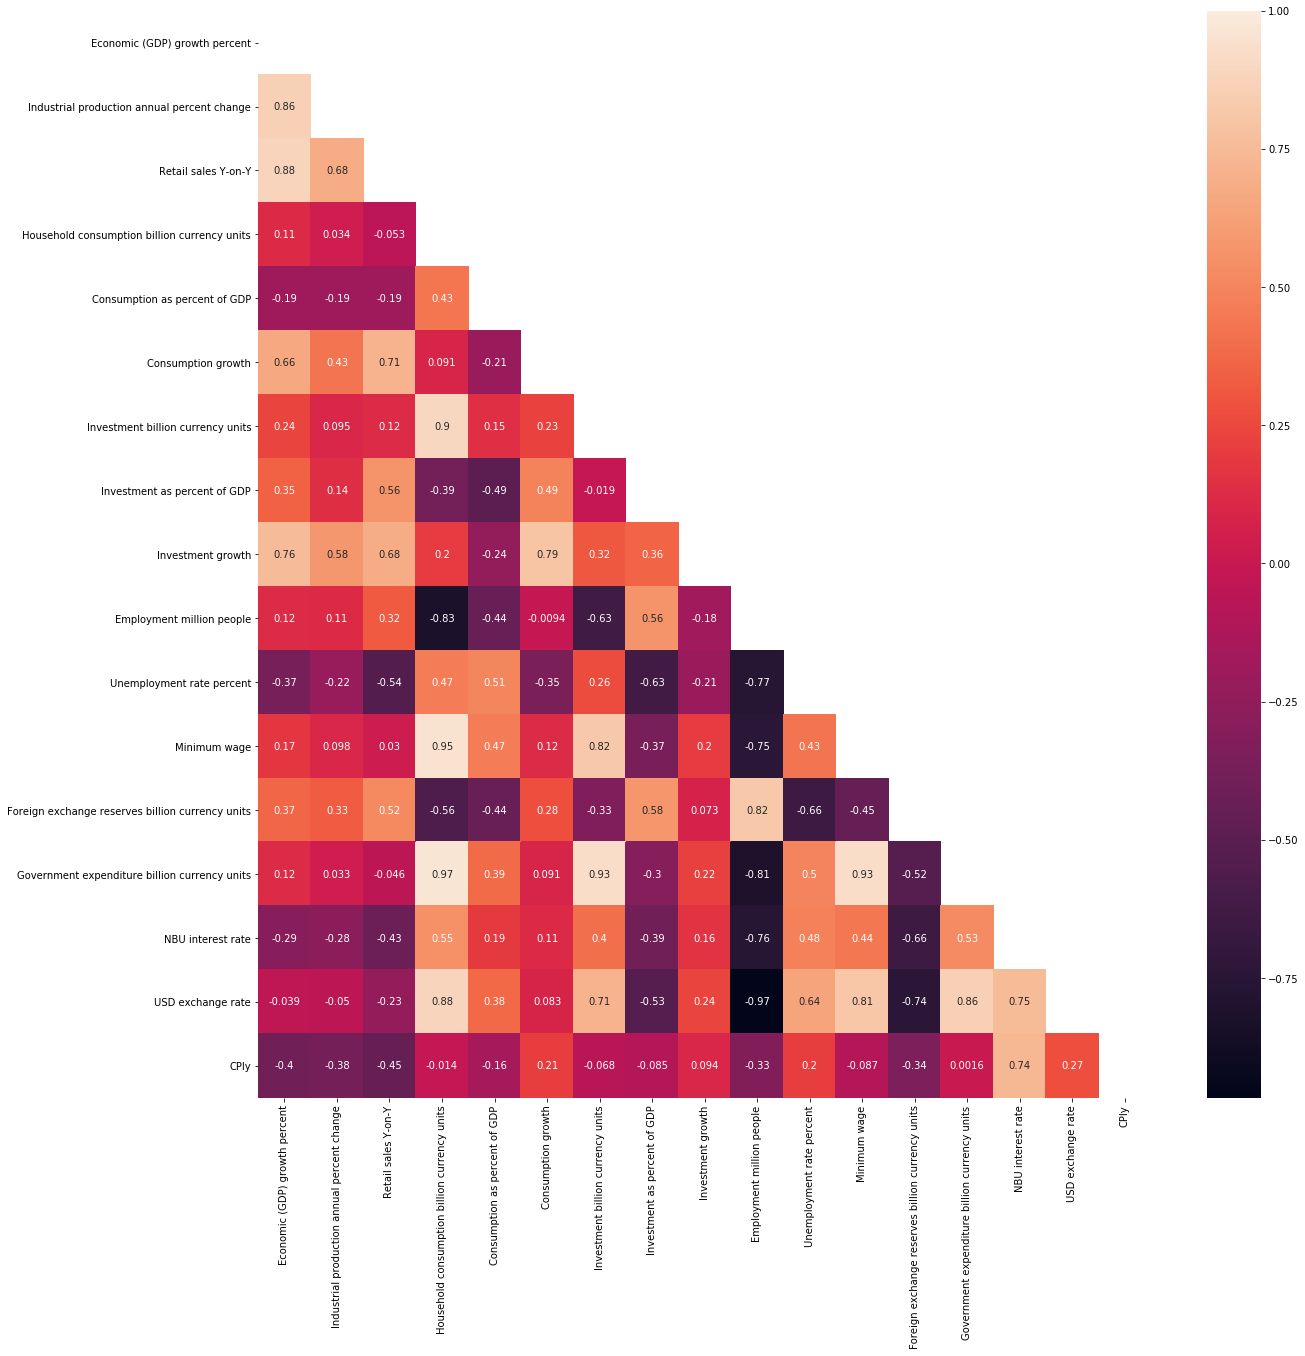

In [0]:
corrplot(xy_CPI_y)

In [0]:
vif_test(x, xy_CPI_y, 'CPIy')

,VIF Factor,features,"r(CPIy, X)"
2,12.6,Retail sales Y-on-Y,-0.452
0,16.9,Economic (GDP) growth percent,-0.402
1,5.9,Industrial production annual percent change,-0.383
11,51.0,Foreign exchange reserves billion currency units,-0.342
9,461.5,Employment million people,-0.329
4,616.1,Consumption as percent of GDP,-0.156
7,127.8,Investment as percent of GDP,-0.085
6,204.1,Investment billion currency units,-0.068
3,258.3,Household consumption billion currency units,-0.014
12,144.7,Government expenditure billion currency units,0.002


# Time Series Analysis

1. ARIMAX
3. VARMA
4. VARMAX
5. SARIMAX
---------------
6. Facebook Prophet

## CPI


### ARIMAX with L2 loss

ARIMA with eXogenous regressors model




In [0]:
model = tsa.arima_model.ARIMA
loss = metrics.mean_squared_error

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPI_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPI_test.index[0],
                y_CPI_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPI_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(0, 0, 6)

In [0]:
x_train_1, x_test_1 = x_train.drop('Minimum wage', axis=1), x_test.drop('Minimum wage', axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



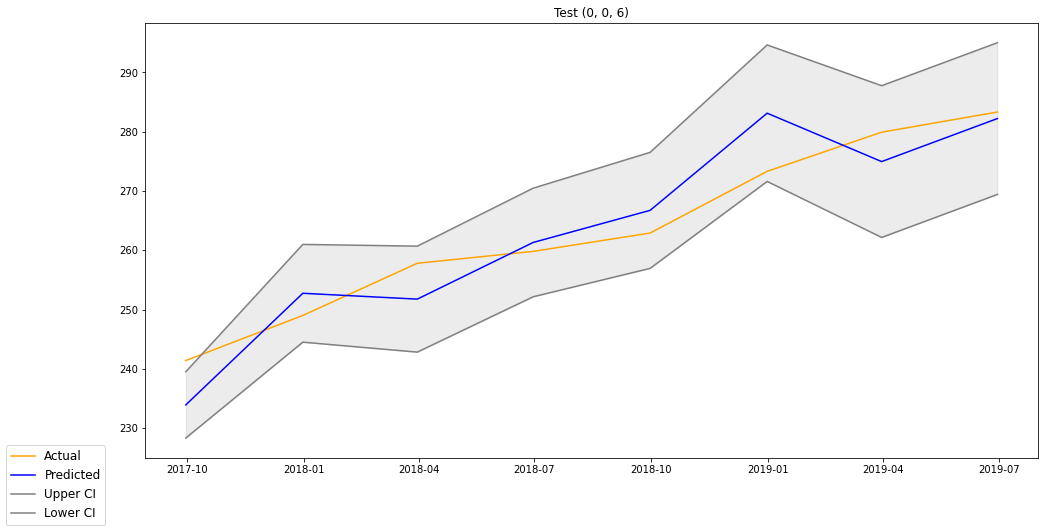

In [0]:
# fit model
parameters = (0,0,6)

model = tsa.arima_model.ARIMA
testset = y_CPI_test
mdl = model(y_CPI_train, parameters, exog=x_train_1).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test_1
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPI_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPI_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPI_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPI_test.index, y_CPI_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPI_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPI_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPI_test.index, lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(y_CPI_test.index, upper, lower, color='grey', alpha=0.15)
ax1.set_title(f'Test {parameters}')
fig.show()

In [0]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                   42
Model:                     ARMA(0, 6)   Log Likelihood                -111.270
Method:                       css-mle   S.D. of innovations              2.850
Date:                Tue, 14 Apr 2020   AIC                            268.541
Time:                        00:29:09   BIC                            308.507
Sample:                    03-31-2007   HQIC                           283.190
                         - 06-30-2017                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               62.1829    121.007      0.514      0.613    -174.987     299.353
Economic (GDP) growth percent                       -0.2197      0.176     -1.246      0.227      -0.565       0.126
Industrial production annual percent change          0.0729      0.101      0.720      0.480      -0.126       0.271
Retail sales Y-on-Y                                  0.1025      0.115      0.890      0.384      -0.123       0.328
Household consumption billion currency units         0.2504      0.105      2.387      0.027       0.045       0.456
Consumption as percent of GDP                       -0.2278      0.377     -0.605      0.552      -0.966       0.511
Consumption growth                                   0.0304      0.119      0.254      0.802      -0.204       0.265
Investment billion currency units                   -0.1998      0.338     -0.591      0.561      -0.862       0.462
Investment as percent of GDP                        -1.4987      1.109     -1.351      0.192      -3.672       0.675
Investment growth                                    0.2041      0.062      3.290      0.004       0.082       0.326
Employment million people                           -0.8616      4.934     -0.175      0.863     -10.531       8.808
Unemployment rate percent                            2.0173      2.529      0.798      0.434      -2.940       6.974
Foreign exchange reserves billion currency units     0.2564      0.230      1.113      0.279      -0.195       0.708
Government expenditure billion currency units        0.2819      0.100      2.828      0.010       0.087       0.477
NBU interest rate                                    1.3557      0.300      4.513      0.000       0.767       1.944
USD exchange rate                                    0.9709      0.499      1.947      0.066      -0.006       1.948
ma.L1.CPI                                            1.0849      0.262      4.143      0.001       0.572       1.598
ma.L2.CPI                                            0.6169      0.235      2.623      0.016       0.156       1.078
ma.L3.CPI                                           -0.3580      0.192     -1.867      0.077      -0.734       0.018
ma.L4.CPI                                            0.6169      0.271      2.276      0.034       0.086       1.148
ma.L5.CPI                                            1.0849      0.345      3.149      0.005       0.410       1.760
ma.L6.CPI                                            1.0000      0.202      4.949      0.000       0.604       1.396
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPI_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPI_test)}')

L2 norm: 30.652953290780147
dtw dist: 13.186800470638069


In [0]:
metrics.r2_score(prediction, y_CPI_test)

0.8779183642685177

### ARIMAX with DTW loss

Dynamic time warping as loss

In [0]:
model = tsa.arima_model.ARIMA
loss = dtw.distance

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPI_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPI_test.index[0],
                y_CPI_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPI_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(1, 0, 0)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



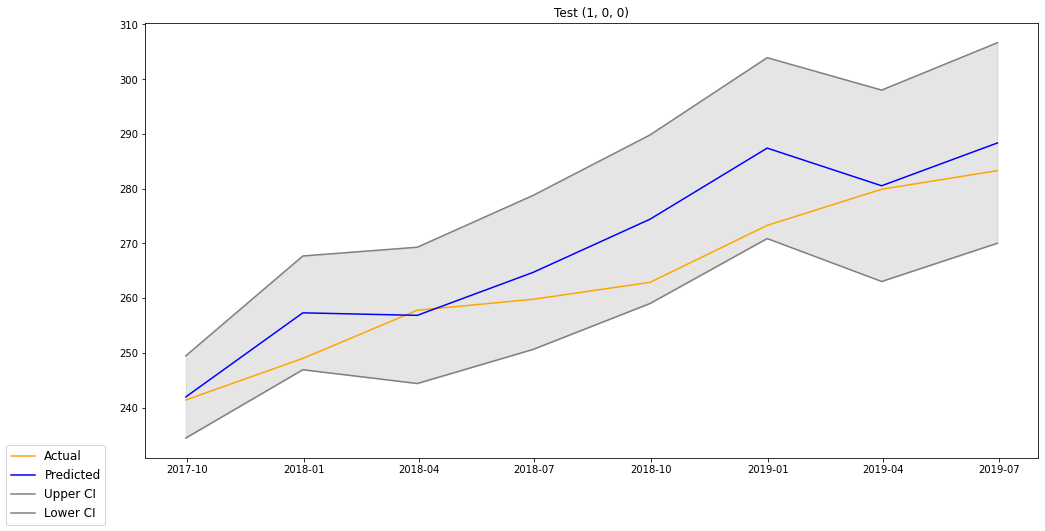

In [0]:
# get forecast
testset = y_CPI_test
mdl = model(y_CPI_train, parameters, exog=x_train).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPI_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPI_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPI_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPI_test.index, y_CPI_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPI_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPI_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPI_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(y_CPI_test.index, lower, upper, color='grey', alpha=0.2)
ax1.set_title(f'Test {parameters}')
fig.show()

In [0]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                   42
Model:                     ARMA(1, 0)   Log Likelihood                -117.242
Method:                       css-mle   S.D. of innovations              3.832
Date:                Mon, 23 Mar 2020   AIC                            270.485
Time:                        22:48:08   BIC                            301.763
Sample:                    03-31-2007   HQIC                           281.949
                         - 06-30-2017                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              235.5633     79.349      2.969      0.007      80.043     391.084
Economic (GDP) growth percent                       -0.2241      0.275     -0.814      0.424      -0.764       0.316
Industrial production annual percent change          0.0922      0.127      0.726      0.474      -0.157       0.341
Retail sales Y-on-Y                                  0.1242      0.144      0.864      0.396      -0.157       0.406
Household consumption billion currency units         0.1695      0.064      2.653      0.014       0.044       0.295
Consumption as percent of GDP                        0.3903      0.272      1.438      0.163      -0.142       0.922
Consumption growth                                  -0.3035      0.171     -1.771      0.089      -0.639       0.032
Investment billion currency units                    0.0788      0.136      0.580      0.567      -0.188       0.345
Investment as percent of GDP                        -1.9976      0.599     -3.333      0.003      -3.172      -0.823
Investment growth                                    0.1699      0.078      2.182      0.039       0.017       0.323
Employment million people                           -7.7997      3.168     -2.462      0.021     -14.010      -1.590
Unemployment rate percent                           -3.9443      1.683     -2.344      0.027      -7.242      -0.647
Foreign exchange reserves billion currency units     0.4629      0.300      1.540      0.136      -0.126       1.052
Government expenditure billion currency units        0.1144      0.063      1.806      0.083      -0.010       0.238
NBU interest rate                                    1.4682      0.331      4.436      0.000       0.819       2.117
USD exchange rate                                    0.6378      0.428      1.490      0.149      -0.201       1.477
ar.L1.CPI                                            0.9555      0.092     10.382      0.000       0.775       1.136
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0465           +0.0000j            1.0465            0.0000
-----------------------------------------------------------------------------
"""

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPI_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPI_test)}')

L2 norm: 56.62940572557531
dtw dist: 11.967199172143573


In [0]:
metrics.r2_score(y_CPI_test, prediction)

0.6984178180565088

### VARMAX - Vector Autoregressive Moving Average with eXogenous variables model

added linear trend

this may come with impulse responses, too. if succeeded with modelling

In [0]:
model = tsa.statespace.varmax.VARMAX
loss = metrics.mean_squared_error

# form parameters' combinations
max_p = (3, 3)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses_cpi = np.zeros(max_p)
losses_general = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(xy_CPI_train, order=params, trend=[1,1]).fit()
        predict = mdl.predict(
                xy_CPI_test.index[0],
                xy_CPI_test.index[-1],
                dynamic=True
                )
        losses_cpi[params] = loss(predict['CPI'], xy_CPI_test['CPI'])
        losses_general[params] = loss(predict, xy_CPI_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses_cpi[params] = -1
        losses_general[params] = -1
        
# pick up best parameters
# print(losses.sum())
losses_cpi = np.nan_to_num(losses_cpi)
losses_general = np.nan_to_num(losses_general)
losses_cpi[losses_cpi<=0] = np.max(losses_cpi)
losses_general[losses_general<=0] = np.max(losses_general)
parameters_cpi = np.unravel_index(np.argmin(losses_cpi), losses_cpi.shape)
parameters_general = np.unravel_index(np.argmin(losses_general), losses_general.shape)
    

In [0]:
losses_cpi = np.nan_to_num(losses_cpi)
losses_general = np.nan_to_num(losses_general)
losses_cpi[losses_cpi<=0] = np.max(losses_cpi)
losses_general[losses_general<=0] = np.max(losses_general)
parameters_cpi = np.unravel_index(np.argmin(losses_cpi), losses_cpi.shape)
parameters_general = np.unravel_index(np.argmin(losses_general), losses_general.shape)
    

In [0]:
print(f'cpi fitting: {parameters_cpi}')
print(f'all: {parameters_general}')

cpi fitting: (1, 1)
all: (1, 1)


In [0]:
# fit model
model = tsa.statespace.varmax.VARMAX
testset = xy_CPI_test
mdl = model(xy_CPI_train, order=(1,1), trend=[1,1]).fit()
predict = mdl.predict(
                xy_CPI_test.index[0],
                xy_CPI_test.index[-1],
                dynamic=True
                )

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:159: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:357: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:159: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



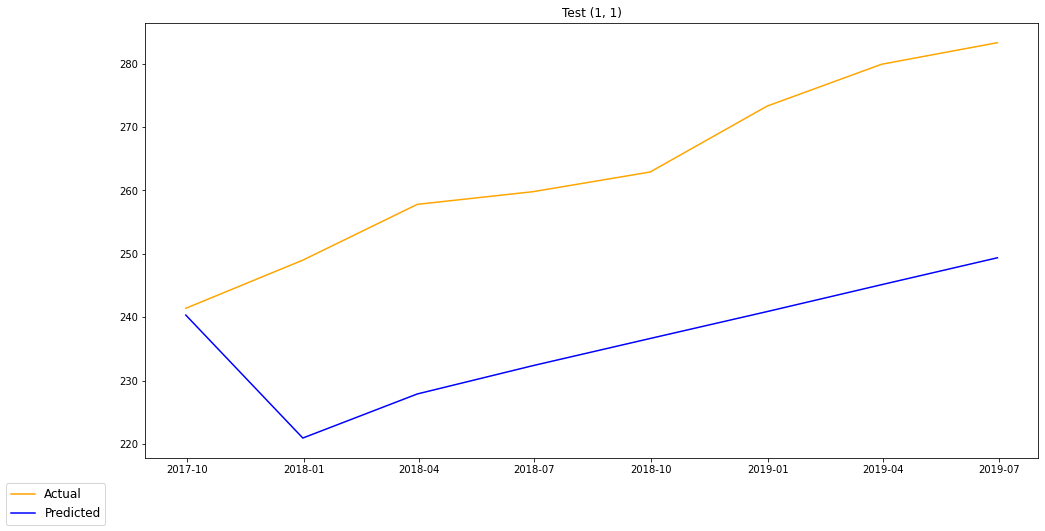

In [0]:
# get prediction
prediction = pd.Series(predict['CPI'], index=xy_CPI_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(xy_CPI_test.index, xy_CPI_test['CPI'], color = 'orange', label = 'Actual')
ax1.plot(xy_CPI_test.index, prediction, color = 'blue',label = 'Predicted' )
fig.legend(loc = 'lower left', fontsize = 12)
ax1.set_title(f'Test {(1,1)}')
fig.show()

In [0]:
metrics.r2_score(xy_CPI_test['CPI'], prediction)

-3.3510650329382274

In [0]:
mdl.summary()

## CPI monthly percent change

### ARIMAX with L2 loss

In [0]:
model = tsa.arima_model.ARIMA
loss = metrics.mean_squared_error

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPIm_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPIm_test.index[0],
                y_CPIm_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPIm_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(5, 2, 0)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



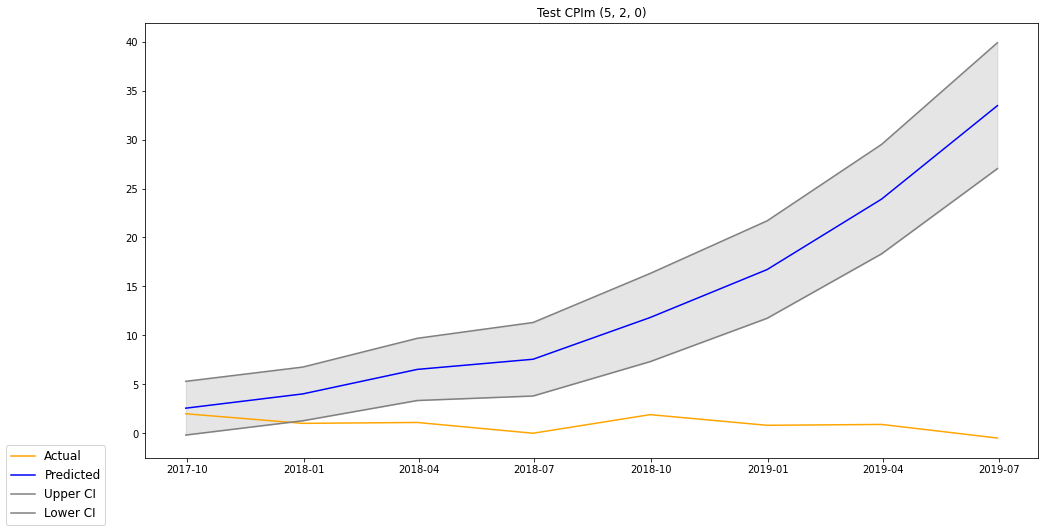

In [0]:
# fit model
# parameters = (5, 2, 0)

model = tsa.arima_model.ARIMA
testset = y_CPIm_test
mdl = model(y_CPIm_train, parameters, exog=x_train).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPIm_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPIm_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPIm_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPIm_test.index, y_CPIm_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPIm_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPIm_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPIm_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(y_CPIm_test.index, lower, upper, color='grey', alpha=0.2)
ax1.set_title(f'Test CPIm {parameters}')
fig.show()

In [0]:
mdl.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                                   ARIMA Model Results                                   
=========================================================================================
Dep. Variable:     D2.CPI monthly percent change   No. Observations:                   40
Model:                            ARIMA(5, 2, 0)   Log Likelihood                 -72.763
Method:                                  css-mle   S.D. of innovations              1.400
Date:                           Mon, 23 Mar 2020   AIC                            189.526
Time:                                   23:19:47   BIC                            226.681
Sample:                               09-30-2007   HQIC                           202.960
                                    - 06-30-2017                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              -83.3277        nan        nan        nan         nan         nan
Economic (GDP) growth percent                        0.3693      0.198      1.863      0.078      -0.019       0.758
Industrial production annual percent change         -0.1625      0.080     -2.023      0.057      -0.320      -0.005
Retail sales Y-on-Y                                  0.0669      0.056      1.202      0.244      -0.042       0.176
Household consumption billion currency units         0.0287      0.032      0.904      0.377      -0.033       0.091
Consumption as percent of GDP                       -0.1350      0.152     -0.888      0.386      -0.433       0.163
Consumption growth                                   0.0388      0.025      1.534      0.142      -0.011       0.088
Investment billion currency units                   -0.0486      0.060     -0.807      0.430      -0.167       0.069
Investment as percent of GDP                         0.0538      0.166      0.324      0.749      -0.271       0.379
Investment growth                                   -0.0384      0.014     -2.826      0.011      -0.065      -0.012
Employment million people                            3.4443      0.325     10.598      0.000       2.807       4.081
Unemployment rate percent                            2.7818      0.467      5.951      0.000       1.866       3.698
Foreign exchange reserves billion currency units    -0.2055      0.047     -4.411      0.000      -0.297      -0.114
Government expenditure billion currency units       -0.0243      0.054     -0.452      0.656      -0.130       0.081
NBU interest rate                                    0.2573      0.069      3.705      0.002       0.121       0.393
USD exchange rate                                    0.1503      0.164      0.914      0.372      -0.172       0.472
ar.L1.D2.CPI monthly percent change                 -2.0233      0.158    -12.841      0.000      -2.332      -1.714
ar.L2.D2.CPI monthly percent change                 -2.4632      0.330     -7.461      0.000      -3.110      -1.816
ar.L3.D2.CPI monthly percent change                 -2.1464      0.446     -4.817      0.000      -3.020      -1.273
ar.L4.D2.CPI monthly percent change                 -1.2292      0.392     -3.133      0.005      -1.998      -0.460
ar.L5.D2.CPI monthly percent change                 -0.3711      0.175     -2.126      0.047      -0.713      -0.029
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0587

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPIm_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPIm_test)}')

L2 norm: 266.4339174688255
dtw dist: 45.87859248741738


In [0]:
metrics.r2_score(prediction, y_CPIm_test)

-1.6180416819755492

### ARIMAX with DTW dist


In [0]:
model = tsa.arima_model.ARIMA
loss = dtw.distance

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPIm_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPIm_test.index[0],
                y_CPIm_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPIm_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(5, 2, 0)

In [0]:
# fit model
model = tsa.arima_model.ARIMA
testset = y_CPIm_test
mdl = model(y_CPIm_train, parameters, exog=x_train).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPIm_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPIm_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPIm_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPIm_test.index, y_CPIm_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPIm_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPIm_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPIm_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(x, lower, upper, color='grey', alpha=0.2)
ax1.set_title(f'Test CPIm {parameters}')
fig.show()

In [0]:
mdl.summary()

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPIm_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPIm_test)}')

## CPI yearly percent change

### ARIMA - NotImplementedError

### ARIMAX with L2 loss

In [0]:
model = tsa.arima_model.ARIMA
loss = metrics.mean_squared_error

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPIy_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPIy_test.index[0],
                y_CPIy_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPIy_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(7, 0, 0)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ConversionError: ignored

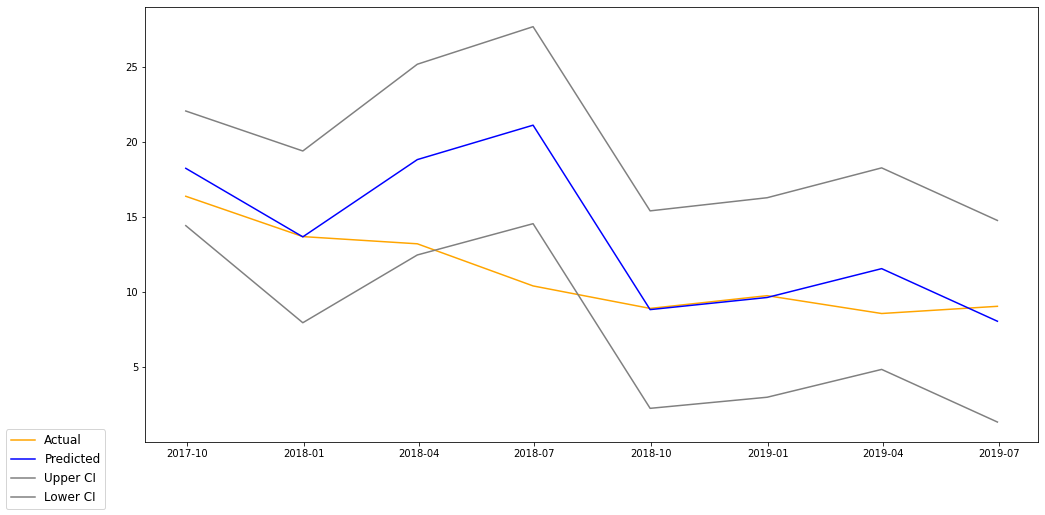

In [0]:
# fit model
parameters = (7, 0, 0)

model = tsa.arima_model.ARIMA
testset = y_CPIy_test
mdl = model(y_CPIy_train, parameters, exog=x_train).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPIy_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPIy_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPIy_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPIy_test.index, y_CPIy_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPIy_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPIy_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPIy_test.index, lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')
ax1.set_title(f'Test CPIm {parameters}')
fig.show()

In [0]:
mdl.summary()

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPIy_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPIy_test)}')

In [0]:
metrics.r2_score(y_CPIy_test, prediction)

-1.8191832266694932

# Regression (with scaled variables)

1. Linear regression

2. Ridge

Lets build a model with scaled variables and response. We will also cut a bit the sataset to omit multicollinearity

In [0]:
x_1 = x.drop([
      'Employment million people', 
      #'Minimum wage'        
], axis=1)
x_1 = sklearn.preprocessing.scale(x)
x_train_1, x_test_1 = train_test_split(x_1, shuffle=False, test_size=0.15)


In [0]:
y_1 = sklearn.preprocessing.scale(y)
y_train_1, y_test_1 = train_test_split(y_1, shuffle=False, )

### Linear regression

In [0]:
# fit model and get predictions
mdl = lm.LinearRegression().fit(x_train_1, y_train)
prediction = mdl.predict(x_test_1)

In [0]:
prediction.shape

(8, 3)

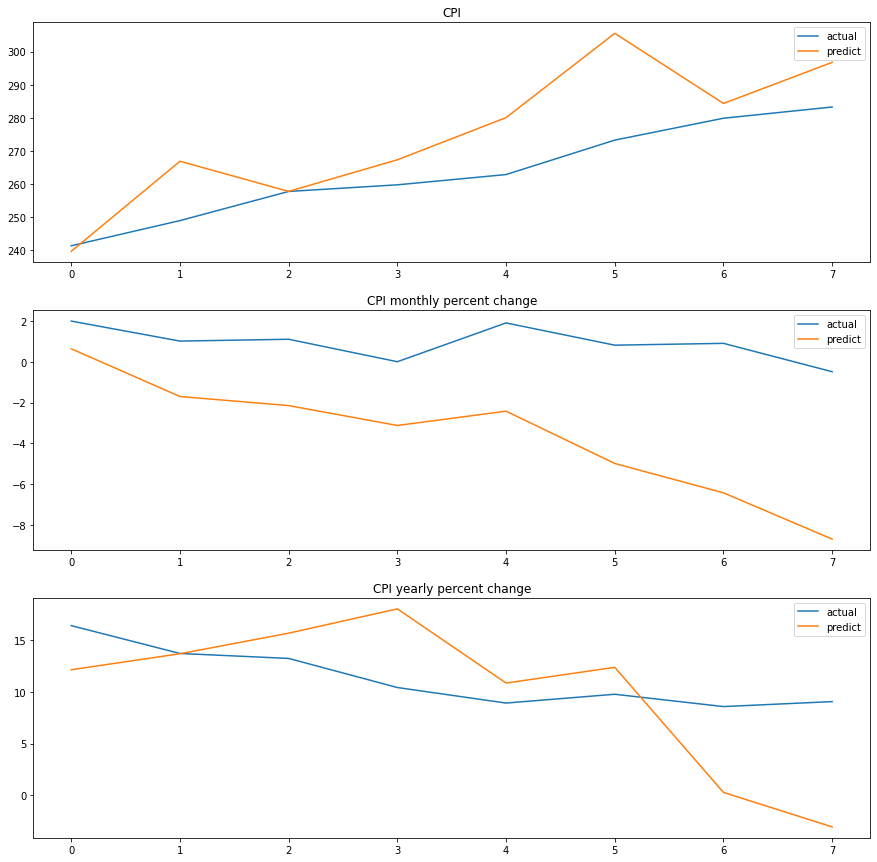

In [0]:
# plot results
fig, ax = plt.subplots(nrows=3, figsize=(15,15))

ax[0].plot(y_test.index, y_test['CPI'], label='actual')
ax[0].plot(y_test.index, prediction[:,0],label='predict')
ax[0].set_title('CPI')

ax[1].plot(y_test.index, y_test['CPIm'], label='actual')
ax[1].plot(y_test.index, prediction[:,1],label='predict')
ax[1].set_title('CPI monthly percent change')

ax[2].plot(y_test.index, y_test['CPIy'], label='actual')
ax[2].plot(y_test.index, prediction[:,2],label='predict')
ax[2].set_title('CPI yearly percent change')

for axis in ax:
    axis.legend()

In [0]:
mdl.score(x_test_1, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').



-0.5525127158086194

so, this is not right. determination is less than 0, so the model is bad somewhere. lets check which one:

In [0]:
lm.LinearRegression().fit(x_train_1, y_CPI_train).score(x_test_1, y_CPI_test)

-0.2766554050292822

In [0]:
lm.LinearRegression().fit(x_train_1, y_CPIm_train).score(x_test_1, y_CPIm_test)

-39.608198570696565

In [0]:
lm.LinearRegression().fit(x_train_1, y_CPIy_train).score(x_test_1, y_CPIy_test)

-4.421766161291805

well, well, it's still better to predict CPI...

### Ridge regression

In [0]:
mdl = lm.Ridge().fit(x_train_1, y_train)
prediction = mdl.predict(x_test_1)

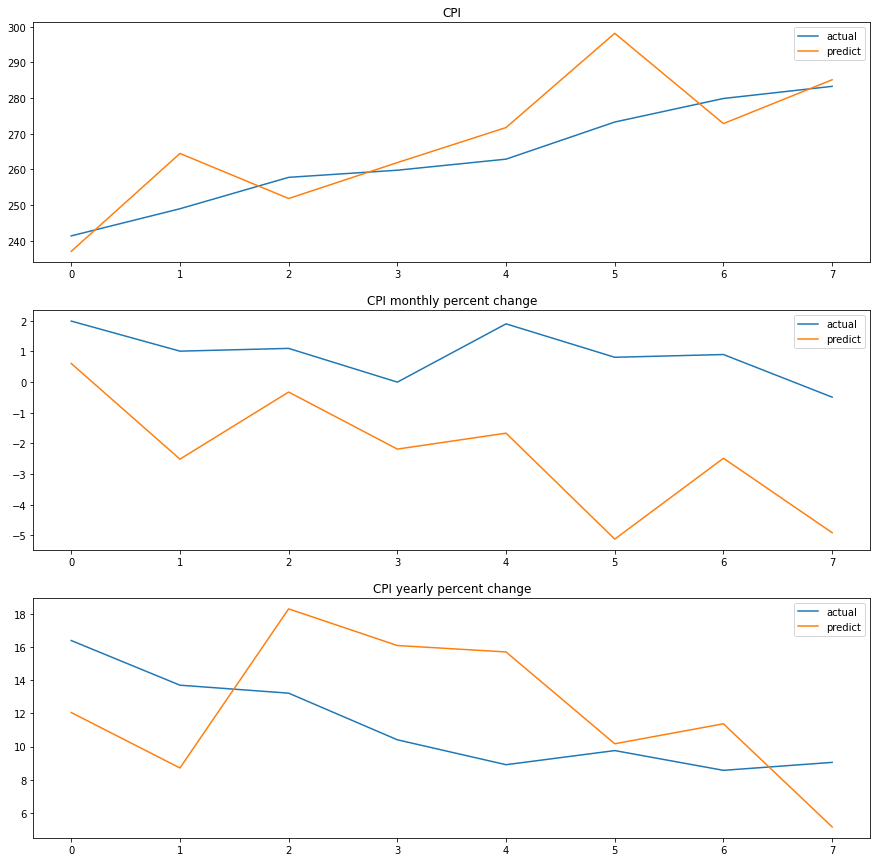

In [0]:
# plot results
fig, ax = plt.subplots(nrows=3, figsize=(15,15))

ax[0].plot(y_test.index, y_test['CPI'], label='actual')
ax[0].plot(y_test.index, prediction[:,0],label='predict')
ax[0].set_title('CPI')

ax[1].plot(y_test.index, y_test['CPIm'], label='actual')
ax[1].plot(y_test.index, prediction[:,1],label='predict')
ax[1].set_title('CPI monthly percent change')

ax[2].plot(y_test.index, y_test['CPIy'], label='actual')
ax[2].plot(y_test.index, prediction[:,2],label='predict')
ax[2].set_title('CPI yearly percent change')

for axis in ax:
    axis.legend()

In [0]:
mdl.score(x_test_1, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').



0.1567392033285512

In [0]:
lm.LinearRegression().fit(x_train_1, y_CPI_train).score(x_test_1, y_CPI_test)

-0.2766554050292822

In [0]:
lm.LinearRegression().fit(x_train_1, y_CPIm_train).score(x_test_1, y_CPIm_test)

-39.608198570696565

In [0]:
lm.LinearRegression().fit(x_train_1, y_CPIy_train).score(x_test_1, y_CPIy_test)

-4.421766161291805

same situation here